In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import plotly.express as px
import plotly
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import networkx as nx
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'utils')))
from beer_knowledge import number_of_beer_per_style, add_global_knowledge, add_local_knowledge, add_experts, get_expert_per_day, get_global_expert_per_day

sns.set_theme()

In [ ]:
df_ba_beers     = pd.read_csv('../data/beer_advocate/beers.csv')
df_ba_breweries = pd.read_csv('../data/beer_advocate/breweries.csv')
df_ba_users     = pd.read_csv('../data/beer_advocate/users.csv')
df_ba_ratings   = pd.read_csv('../data/beer_advocate/ratings.csv')

In [6]:
df_rb_beers     = pd.read_csv('../data/rate_beer/beers.csv')
df_rb_breweries = pd.read_csv('../data/rate_beer/breweries.csv')
df_rb_users     = pd.read_csv('../data/rate_beer/users.csv')
df_rb_ratings   = pd.read_csv('../data/rate_beer/ratings.csv')

In [7]:
df_rb_ratings["beer_global_style"].unique()

array(['Pale Lager', 'Pale Ale', 'Porter', 'Brown Ale', 'Speciality Beer',
       'India Pale Ale', 'Hybrid Beer', 'Dark Lager', 'Stout',
       'Strong Ale', 'Wheat Beer', 'Bock', 'Wild/Sour Beer', 'Dark Ales'],
      dtype=object)

In [8]:
df_ba_ratings['day']     = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('D')
df_ba_ratings['week']    = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('W').dt.start_time
df_ba_ratings['month']   = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('M').dt.start_time
df_ba_ratings['quarter'] = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('Q')
df_ba_ratings['year']    = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('Y')

df_rb_ratings['day']     = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('D')
df_rb_ratings['week']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('W').dt.start_time
df_rb_ratings['month']   = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('M').dt.start_time
df_rb_ratings['quarter'] = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Q')
df_rb_ratings['year']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Y')

# Pre-processing 

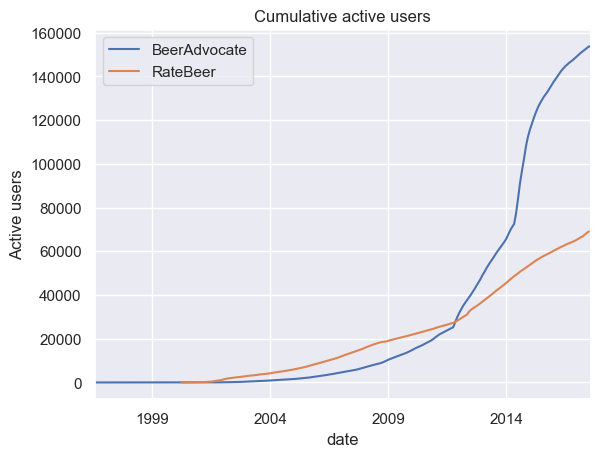

In [9]:
plt.title('Cumulative active users')
plt.xlabel('Month')
plt.ylabel('Active users')
pd.to_datetime(df_ba_ratings.sort_values(['date']).groupby('user_id')['date'].first(), unit='s').dt.to_period('M').value_counts().sort_index().cumsum().plot(label='BeerAdvocate')
pd.to_datetime(df_rb_ratings.sort_values(['date']).groupby('user_id')['date'].first(), unit='s').dt.to_period('M').value_counts().sort_index().cumsum().plot(label='RateBeer')
plt.legend()

In [10]:
def compute_cumulative_ratings_count(dataframe: pd.DataFrame):
    dataframe = dataframe.sort_values(['date'])
    dataframe['_count'] = 1
    dataframe['cumulative_ratings_count'] = dataframe['_count'].cumsum()
    dataframe = dataframe.drop(columns=['_count'])
    return dataframe

<Axes: title={'center': 'Cumulative ratings count'}, xlabel='month', ylabel='Cumulative ratings count'>

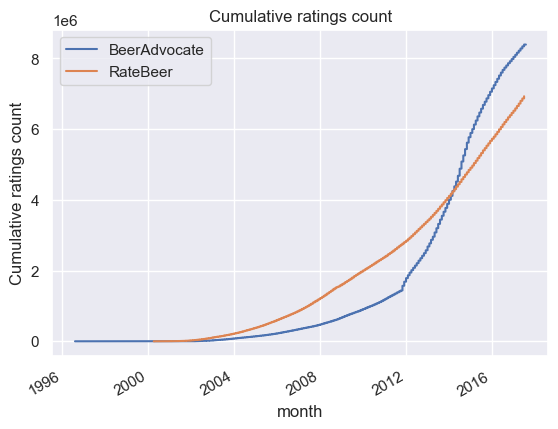

In [11]:
fig, ax = plt.subplots()
plt.title('Cumulative ratings count')
plt.xlabel('Month')
plt.ylabel('Cumulative ratings count')
compute_cumulative_ratings_count(df_ba_ratings).plot(x='month', y='cumulative_ratings_count', label='BeerAdvocate', ax=ax)
compute_cumulative_ratings_count(df_rb_ratings).plot(x='month', y='cumulative_ratings_count', label='RateBeer', ax=ax)

**Internet majority adoption is around 2004 (50% of population using it regularly) + lot of noise before 2004 so the analysis will focus on the time period after January 2004**

In [307]:
def remove_before_month(dataframe: pd.DataFrame, month: str = '2004-01') -> pd.DataFrame:
    dataframe = dataframe.sort_values(['user_id', 'date'])
    dataframe = dataframe.merge(
        (dataframe.groupby('user_id')['month'].first() >= month).reset_index().rename(columns={'month': 'is_first_rating_after_month'}),
        on='user_id'
    )
    dataframe = dataframe[dataframe['is_first_rating_after_month']]
    dataframe = dataframe.drop(columns=['is_first_rating_after_month'])
    return dataframe

In [13]:
df_ba_ratings = remove_before_month(df_ba_ratings, '2004-01')
df_rb_ratings = remove_before_month(df_rb_ratings, '2004-01')

# 1. Inflations

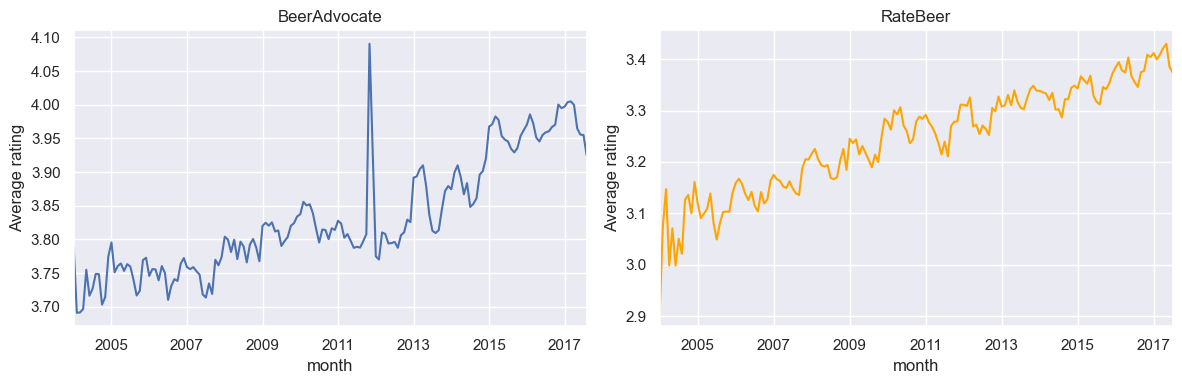

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Average rating')
df_ba_ratings.groupby('month')['rating'].mean().plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Average rating')
df_rb_ratings.groupby('month')['rating'].mean().plot(ax=axs[1], color='orange')

plt.tight_layout()

In [15]:
def create_time_serie(dataframe: pd.DataFrame, time_column: str, value_column: str, frequency: str = 'W') -> pd.DataFrame:
    full_range = pd.DataFrame(index=pd.date_range(start=dataframe[time_column].min(), end=dataframe[time_column].max(), freq=frequency).to_period('W').start_time)
    partial_time_serie = dataframe.groupby(time_column)[value_column].mean()
    time_serie = pd.merge(full_range, partial_time_serie, left_index=True, right_index=True, how='left').fillna(0)
    return time_serie

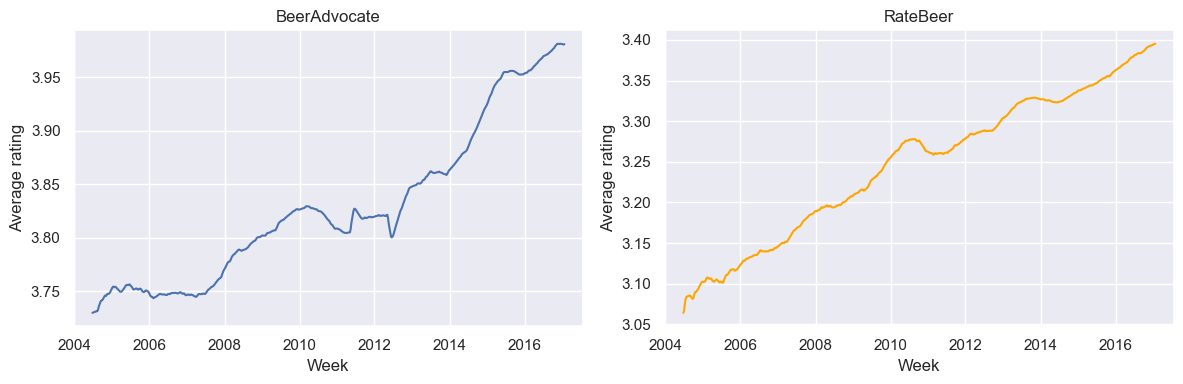

In [16]:
df_ba_decomposition = seasonal_decompose(create_time_serie(df_ba_ratings, 'week', 'rating'), model='additive', period=52)
df_rb_decomposition = seasonal_decompose(create_time_serie(df_rb_ratings, 'week', 'rating'), model='additive', period=52)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Rating general trend')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Average rating')
df_ba_decomposition.trend.plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Average rating')
df_rb_decomposition.trend.plot(ax=axs[1], color='orange')

plt.tight_layout()

In [17]:
def correct_inflation(dataframe: pd.DataFrame, trend: pd.Series) -> pd.DataFrame:
    trend = trend.dropna()
    reference_mean = trend.iloc[0]
    IPC = trend / reference_mean
    
    dataframe = dataframe.loc[dataframe['week'] >= trend.index[0]]

    beta_0 = IPC.iloc[0]
    beta_1 = (IPC.iloc[-1] - IPC.iloc[0]) / len(IPC)

    for week in pd.date_range(start=IPC.index.max(), end=dataframe['week'].max(), freq='W').to_period('W').start_time:
        diff = (week + pd.Timedelta(weeks=1) - IPC.index.min()) / pd.Timedelta(weeks=1)
        IPC.loc[week + pd.Timedelta(weeks=1)] = beta_0 + beta_1 * diff
    
    dataframe['rating_corrected'] = dataframe['rating'] / IPC.reindex(dataframe['week']).values
    return dataframe

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_91307/3935964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['rating_corrected'] = dataframe['rating'] / IPC.reindex(dataframe['week']).values
/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_91307/3935964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['rating_corrected'] = dataframe['rating'] / IPC.reindex(dataframe['week']).values


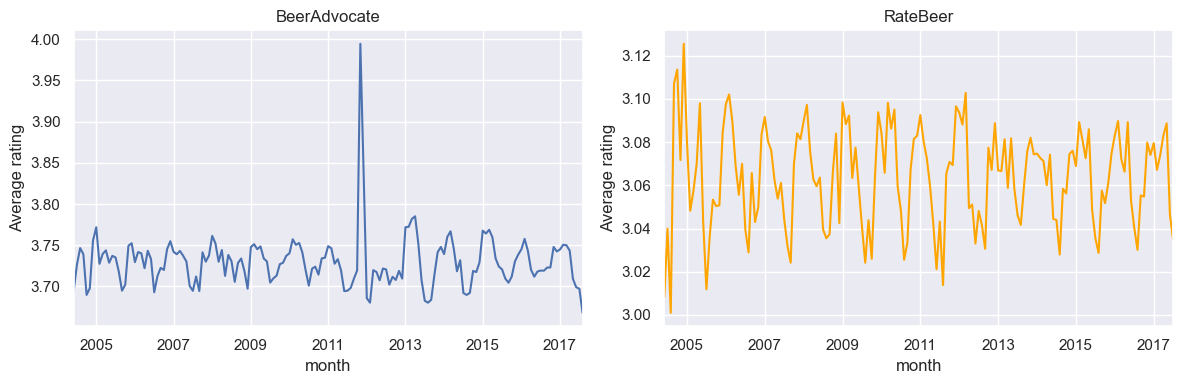

In [18]:
df_ba_ratings = correct_inflation(df_ba_ratings, df_ba_decomposition.trend)
df_rb_ratings = correct_inflation(df_rb_ratings, df_rb_decomposition.trend)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Rating average over time corrected for inflation')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Average rating')
df_ba_ratings.groupby('month')['rating_corrected'].mean().plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Average rating')
df_rb_ratings.groupby('month')['rating_corrected'].mean().plot(ax=axs[1], color='orange')

plt.tight_layout()

# 2. Rating scales

In [19]:
def compute_scale_distribution(dataframe: pd.DataFrame) -> pd.DataFrame:
    new_dataframe = dataframe.groupby('user_id')['rating_corrected'].quantile([0.01, 0.025, 0.05, 0.1, 0.9, 0.95, 0.975, 0.99]).unstack()
    new_dataframe = new_dataframe.merge(dataframe.groupby('user_id')['rating_corrected'].count(), left_index=True, right_index=True)
    new_dataframe = new_dataframe.rename(columns={'rating_corrected': 'count'}).dropna()
    new_dataframe['difference'] = new_dataframe[0.975] - new_dataframe[0.025]
    new_dataframe.columns = [str(c) for c in new_dataframe.columns]
    return new_dataframe

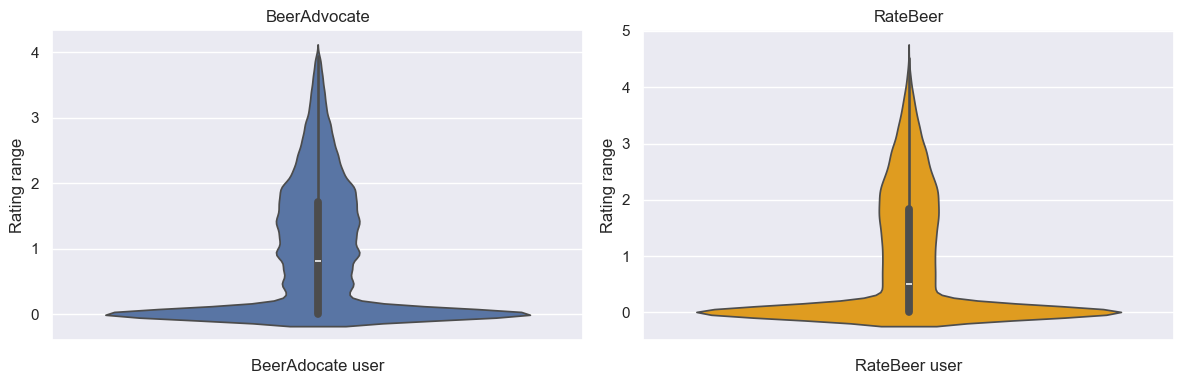

In [20]:
df_ba_scales = compute_scale_distribution(df_ba_ratings)
df_rb_scales = compute_scale_distribution(df_rb_ratings)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Distribution of rating range')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('BeerAdocate user')
axs[0].set_ylabel('Rating range')
sns.violinplot(df_ba_scales['difference'], ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('RateBeer user')
axs[1].set_ylabel('Rating range')
sns.violinplot(df_rb_scales['difference'], ax=axs[1], color='orange')

plt.tight_layout()

In [21]:
for threshold in [10, 50, 100, 500, 1000]:
    df_ba_scales[f'at_least_{threshold}'] = (df_ba_scales['count'] > threshold).astype(int) * threshold
    df_rb_scales[f'at_least_{threshold}'] = (df_rb_scales['count'] > threshold).astype(int) * threshold

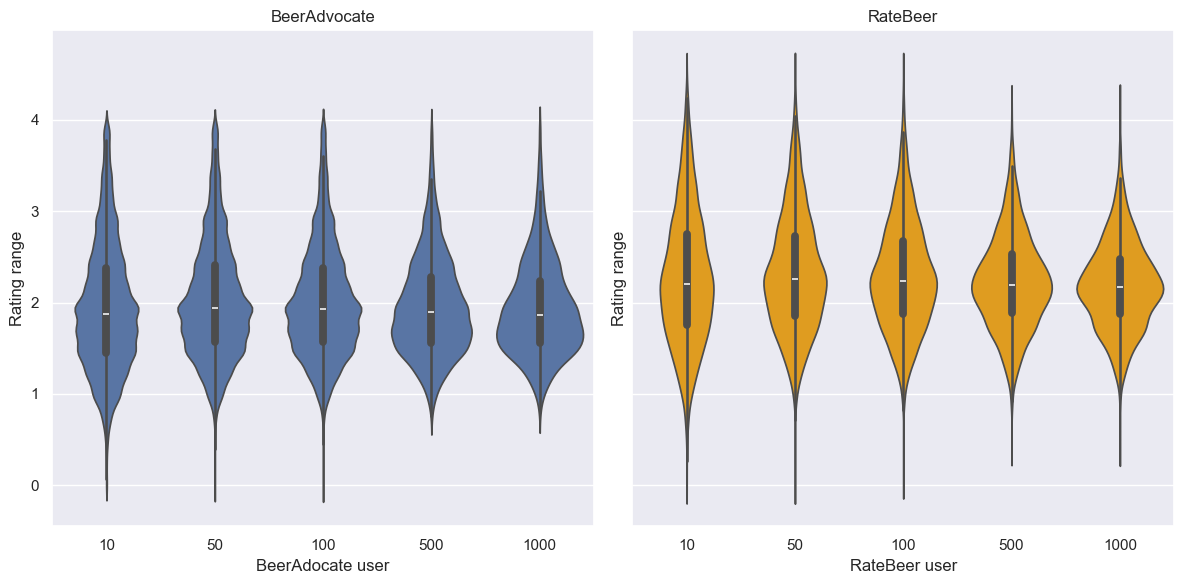

In [22]:
df_ba_scales = pd.wide_to_long(df_ba_scales.reset_index(), stubnames='at_least_', i='user_id', j='threshold').reset_index().drop(columns=['at_least_'])
df_rb_scales = pd.wide_to_long(df_rb_scales.reset_index(), stubnames='at_least_', i='user_id', j='threshold').reset_index().drop(columns=['at_least_'])

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.title('Distribution of rating ranges')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('BeerAdocate user')
axs[0].set_ylabel('Rating range')
sns.violinplot(data=df_ba_scales[df_ba_scales['count'] > df_ba_scales['threshold']], x='threshold', y='difference', ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('RateBeer user')
axs[1].set_ylabel('Rating range')
sns.violinplot(df_rb_scales[df_rb_scales['count'] > df_rb_scales['threshold']], x='threshold', y='difference', ax=axs[1], color='orange')

plt.tight_layout()

# Past ratings and count

In [28]:
def get_past_ratings_count_and_average(
    df_ratings: pd.DataFrame,
    sorting_columns: list[str],
    grouping_columns: list[str],
    name: str,
    shift: bool,
) -> pd.DataFrame:
    df_ratings = df_ratings.sort_values(sorting_columns, kind="stable")

    if shift:
        df_ratings[f"{name}_past_ratings_count"] = df_ratings.groupby(
            grouping_columns
        ).cumcount()
        df_ratings[f"{name}_past_ratings_average"] = (
            df_ratings.groupby(grouping_columns)["rating_corrected"]
            .expanding()
            .mean()
            .shift()
            .reset_index(level=[i for i in range(len(grouping_columns))], drop=True)
        )
    else:
        df_ratings[f"{name}_past_ratings_count"] = (
            df_ratings.groupby(grouping_columns).cumcount() + 1
        )
        df_ratings[f"{name}_past_ratings_average"] = (
            df_ratings.groupby(grouping_columns)["rating_corrected"]
            .expanding()
            .mean()
            .reset_index(level=[i for i in range(len(grouping_columns))], drop=True)
        )

    df_ratings.loc[
        df_ratings[f"{name}_past_ratings_count"] == 0, f"{name}_past_ratings_average"
    ] = pd.NA

    df_ratings = df_ratings.sort_index()
    return df_ratings

def get_past_ratings_counts_all_style(
    df_ratings: pd.DataFrame, dummy_column: str, multiplying_columns_prefix: str
) -> pd.DataFrame:
    # Create one-hot encoded binary matrix for the beer styles
    beer_styles_one_hot_encoding = pd.get_dummies(
        df_ratings[dummy_column], dtype=int, prefix="user_past_ratings"
    ).replace(0, pd.NA)

    # Multiply the binary matrix with the past ratings count and average corresponding to the current rating style
    df_user_beer_style_past_ratings = pd.merge(
        beer_styles_one_hot_encoding.mul(
            df_ratings[f"{multiplying_columns_prefix}_past_ratings_count"], axis=0
        ),
        beer_styles_one_hot_encoding.mul(
            df_ratings[f"{multiplying_columns_prefix}_past_ratings_average"], axis=0
        ),
        left_index=True,
        right_index=True,
        suffixes=("_count", "_average"),
    )

    modified_columns = [
        column
        for column in df_user_beer_style_past_ratings.columns
        if ("_count" in column or "_average" in column)
    ]

    # Merge to get the user id and date in order to forward fill the values within groups of user_id
    df_user_beer_style_past_ratings = df_user_beer_style_past_ratings.merge(
        df_ratings[["user_id", "date", "beer_id"]],
        left_index=True,
        right_index=True,
        how="left",
    )

    # Ensure duplicate are well sorted by the next sorting
    df_user_beer_style_past_ratings.sort_index(inplace=True)

    # Fill forward the values within groups of user_id
    df_user_beer_style_past_ratings[modified_columns] = (
        df_user_beer_style_past_ratings.sort_values(["user_id", "date"], kind="stable")
        .groupby("user_id")
        .ffill()[modified_columns]
    )

    # Shift the value forward to have the counts and average without taking into
    # account the current rating (since counts and average are computed taking
    # into account current rating)
    df_user_beer_style_past_ratings[modified_columns] = (
        df_user_beer_style_past_ratings.sort_values(["user_id", "date"], kind="stable")
        .groupby("user_id")
        .shift(1)[modified_columns]
    )

    # Fill remaining cells with 0 as they are cells of ratings occuring before
    # the first rating in a given beer style
    df_user_beer_style_past_ratings[modified_columns] = df_user_beer_style_past_ratings[
        modified_columns
    ].fillna(0.0)

    return df_user_beer_style_past_ratings



In [24]:
df_ba_ratings = get_past_ratings_count_and_average(
    df_ba_ratings, ["user_id", "date"], ["user_id"], "user", shift=True
)

df_ba_ratings = get_past_ratings_count_and_average(
    df_ba_ratings, ["beer_id", "date"], ["beer_id"], "beer", shift=True
)

df_ba_ratings = get_past_ratings_count_and_average(
    df_ba_ratings,
    ["user_id", "beer_global_style", "date"],
    ["user_id", "beer_global_style"],
    "user_beer_style",
    shift=False,
)

df_ba_user_beer_style_past_ratings = get_past_ratings_counts_all_style(
    df_ba_ratings, "beer_global_style", "user_beer_style"
)

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_91307/1277939718.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ].fillna(0.0)


In [25]:
df_rb_ratings = get_past_ratings_count_and_average(
    df_rb_ratings, ["user_id", "date"], ["user_id"], "user", shift=True
)

df_rb_ratings = get_past_ratings_count_and_average(
    df_rb_ratings, ["beer_id", "date"], ["beer_id"], "beer", shift=True
)

df_rb_ratings = get_past_ratings_count_and_average(
    df_rb_ratings,
    ["user_id", "beer_global_style", "date"],
    ["user_id", "beer_global_style"],
    "user_beer_style",
    shift=False,
)

df_rb_user_beer_style_past_ratings = get_past_ratings_counts_all_style(
    df_rb_ratings, "beer_global_style", "user_beer_style"
)

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_91307/1277939718.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ].fillna(0.0)


In [26]:
df_ba_user_beer_style_past_ratings.to_csv("../data/beer_advocate/user_beer_style_past_ratings_inflation.csv",index=False)
df_rb_user_beer_style_past_ratings.to_csv("../data/rate_beer/user_beer_style_past_ratings_inflation.csv",index=False)

In [27]:
df_rb_ratings.to_csv("../data/rate_beer/ratings_inflation.csv",index=False)
df_ba_ratings.to_csv("../data/beer_advocate/ratings_inflation.csv",index=False)

# Knowledge

# Beer Advocate

In [438]:
df_ba_user_beer_style_past_ratings = pd.read_csv("../data/beer_advocate/user_beer_style_past_ratings.csv")
df_ba_ratings = pd.read_csv("../data/beer_advocate/ratings.csv")

In [439]:
df_ba_ratings.loc[:,"user_beer_style_past_ratings_count"] = df_ba_ratings["user_beer_style_past_ratings_count"] - 1
df_ba_ratings.loc[df_ba_ratings["user_beer_style_past_ratings_count"] == 0,"user_beer_style_past_ratings_average"] = np.nan
df_ba_ratings['date_day'] = pd.to_datetime(df_ba_ratings['date'], unit="s").dt.round('D')
df_ba_ratings.drop(df_ba_ratings[df_ba_ratings["beer_global_style"] == "Low Alcohol Beer"].index, axis=0, inplace=True)

#To preprocess once and for all
df_ba_user_beer_style_past_ratings['date_day'] = pd.to_datetime(df_ba_user_beer_style_past_ratings['date'], unit="s").dt.round('D')
df_ba_user_beer_style_past_ratings.drop(["user_past_ratings_Low Alcohol Beer_count","user_past_ratings_Low Alcohol Beer_average"],axis=1,inplace=True)

In [440]:
df_current_beer_per_style = number_of_beer_per_style(df_ba_ratings)
df_current_beer_per_style.drop(df_current_beer_per_style[df_current_beer_per_style["date_day"] < "2004-01-01"].index, axis=0, inplace=True)

In [441]:
df_ba_ratings['month']   = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('M').dt.start_time
df_ba_ratings = remove_before_month(df_ba_ratings, '2004-01')

In [442]:
df_ba_user_beer_style_past_ratings = df_ba_user_beer_style_past_ratings[df_ba_user_beer_style_past_ratings["user_id"].isin(df_ba_ratings["user_id"].drop_duplicates())]

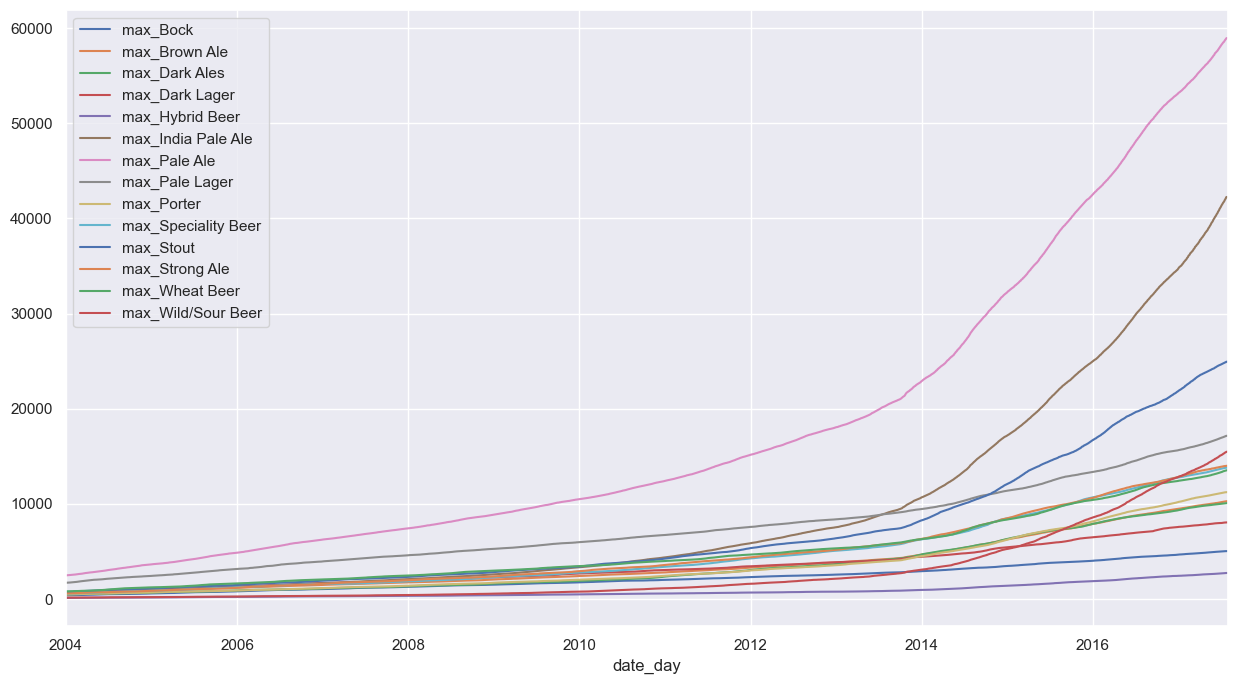

In [443]:
df_current_beer_per_style.plot(x="date_day",grid=True,figsize=(15,8))
plt.show()

<u style="background-color:red;">Interpretation:</u> : Growing number of available beer with a bigger slope since 2003 and then agan in 2013

In [444]:
average_columns = [col for col in df_ba_user_beer_style_past_ratings.columns if "average" in col]
count_columns = [col for col in df_ba_user_beer_style_past_ratings.columns if "count" in col]
max_columns = [col for col in df_current_beer_per_style.columns if "max" in col]

In [445]:
df_ba_user_beer_style_past_ratings = add_global_knowledge(df_current_beer_per_style, df_ba_user_beer_style_past_ratings, count_columns)
df_ba_user_beer_style_past_ratings, df_local_knowledge = add_local_knowledge(df_current_beer_per_style, df_ba_user_beer_style_past_ratings, max_columns, count_columns)

df_knowledge = df_ba_user_beer_style_past_ratings[["user_id","date_day","beer_id","global_knowledge","local_knowledge","style_tried"]]
df_knowledge.loc[:,"knowledge"] = (df_knowledge["global_knowledge"]+df_knowledge["local_knowledge"])/2

df_knowledge = df_knowledge.drop(df_knowledge[df_knowledge["local_knowledge"] == 0].index, axis=0)

df_prime_knowledge = df_knowledge[["user_id","global_knowledge","local_knowledge","knowledge"]].groupby("user_id").max().reset_index()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1020940568.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



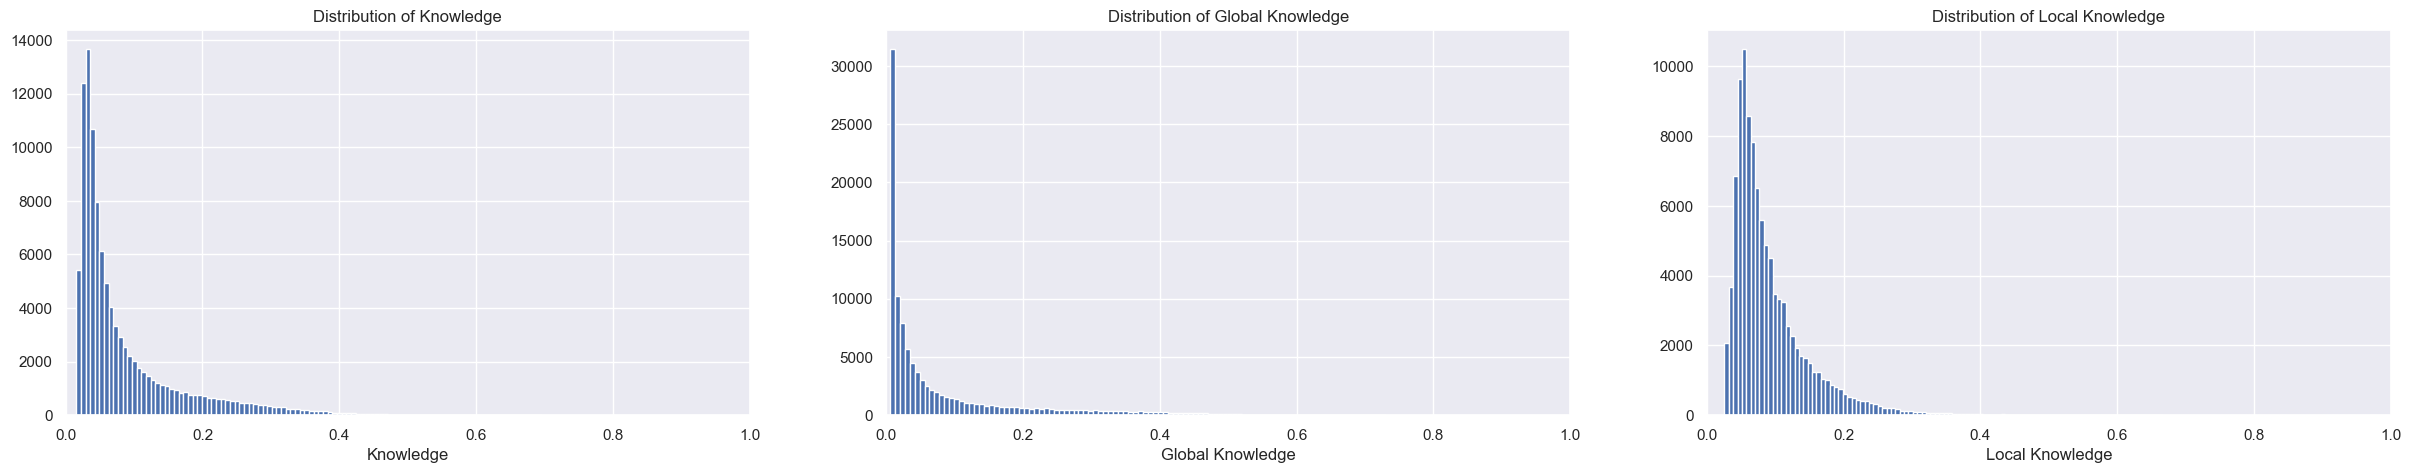

In [446]:
plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
df_prime_knowledge["knowledge"].hist(bins=100)
plt.title("Distribution of Knowledge")
plt.xlabel("Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,2)
df_prime_knowledge["global_knowledge"].hist(bins=100)
plt.title("Distribution of Global Knowledge")
plt.xlabel("Global Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,3)
df_prime_knowledge["local_knowledge"].hist(bins=100)
plt.title("Distribution of Local Knowledge")
plt.xlabel("Local Knowledge")
plt.xlim([0,1])

plt.show()

<u style="background-color:red;">Interpretation:</u> : Right-skewed distribution for the *knowledge* as the user with high knowledge are quite rare. It's clear for the *global knowledge* that it is almost impossible to reach a really high level mostly because of the size of the beer dataset. Finally the *local knowledge* is more evenly distributed between 0 and 0.6 highlighting the clear possibility to find a beer style in which one's can thrive.

In [447]:
df_highest_global_knowledge = df_knowledge.loc[df_knowledge[["user_id","global_knowledge"]].groupby("user_id").idxmax().reset_index()["global_knowledge"]]

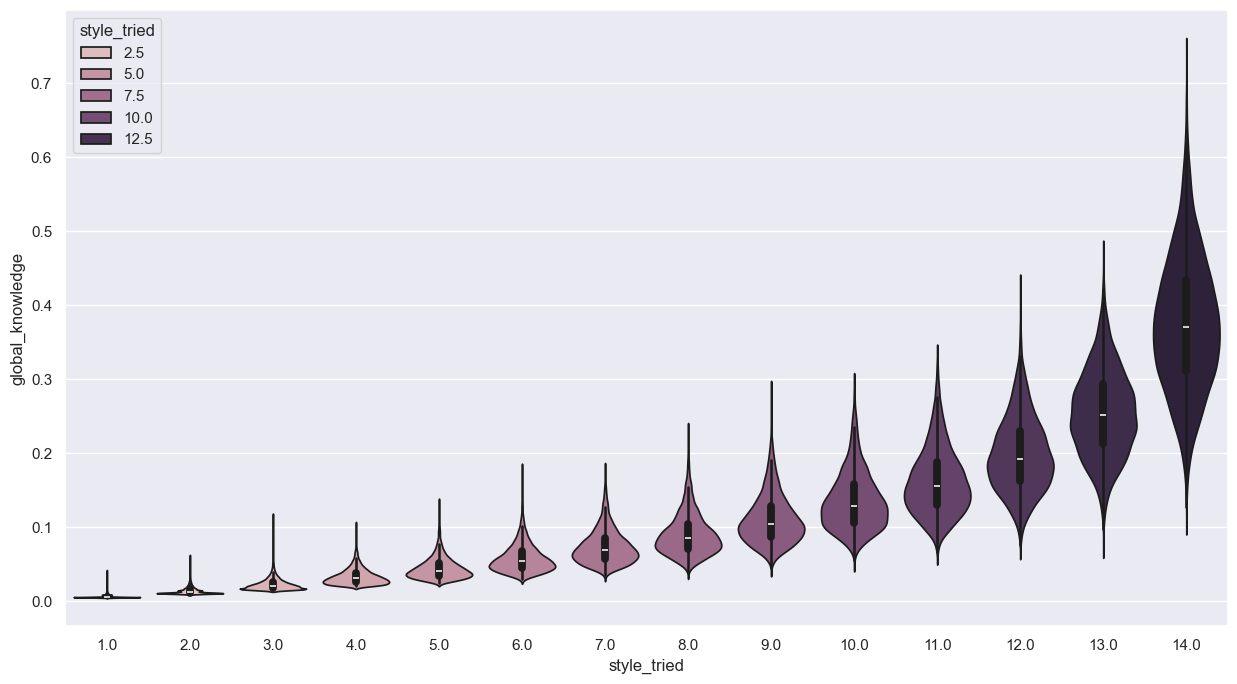

In [448]:
plt.figure(figsize=(15,8))
sns.violinplot(x=df_highest_global_knowledge["style_tried"],y=df_highest_global_knowledge["global_knowledge"],hue=df_highest_global_knowledge["style_tried"])
plt.show()

In [449]:
df_highest_global_knowledge_per_style_tried = df_knowledge.loc[df_knowledge[["user_id","global_knowledge","style_tried"]].groupby(["user_id","style_tried"]).idxmax().reset_index()["global_knowledge"]]

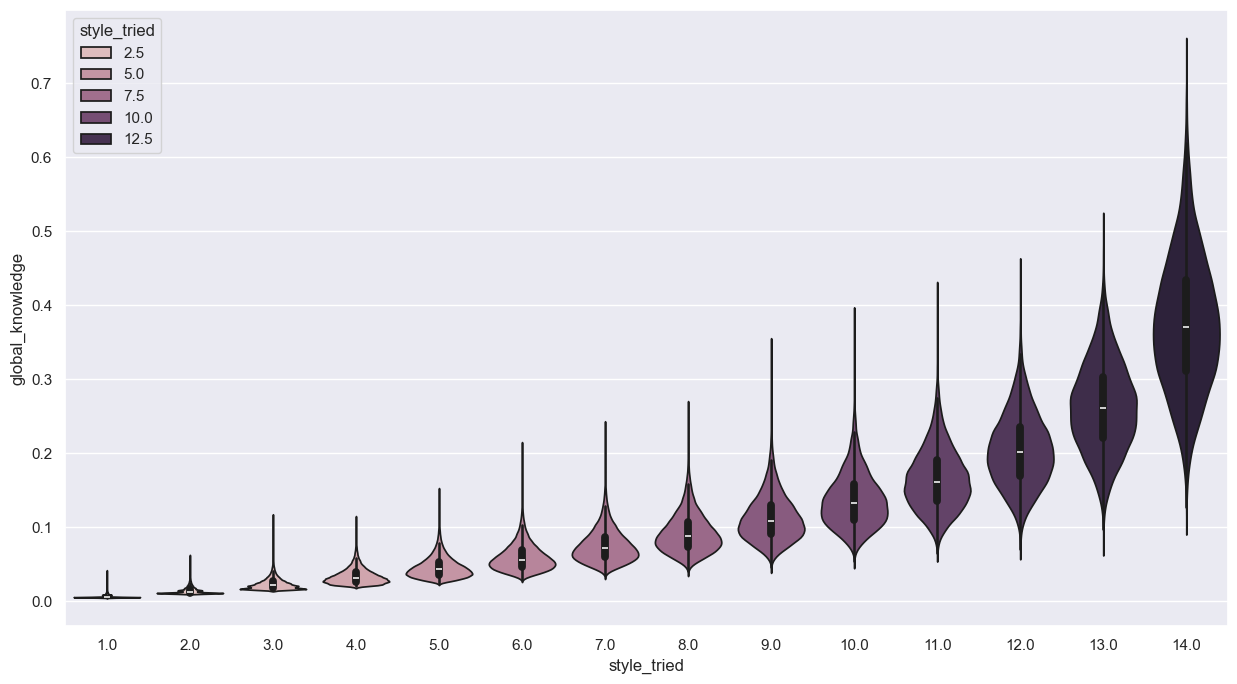

In [450]:
plt.figure(figsize=(15,8))
sns.violinplot(x=df_highest_global_knowledge_per_style_tried["style_tried"],y=df_highest_global_knowledge_per_style_tried["global_knowledge"],hue=df_highest_global_knowledge_per_style_tried["style_tried"])
plt.show()

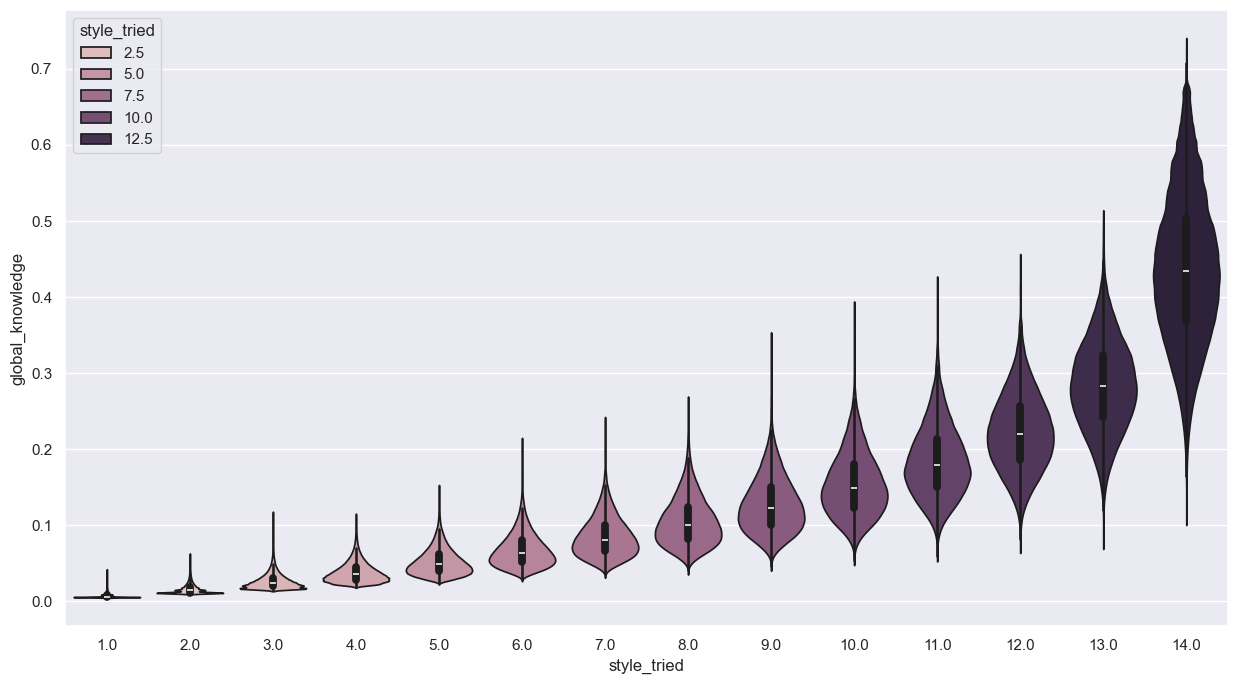

In [451]:
plt.figure(figsize=(15,8))
sns.violinplot(x=df_knowledge["style_tried"],y=df_knowledge["global_knowledge"],hue=df_knowledge["style_tried"])
plt.show()

<u style="background-color:red;">Interpretation:</u> : Although the number of beer style tried has quite of an impact on the *global knowledge* of a user, it is not impossible to reach a reasonable amount without trying all the styles. 

### CHOOSE BEST VIZ AMONGST THREE ABOVE

In [452]:
df_prime_local_knowledge = df_local_knowledge.iloc[:,:-1].groupby("user_id").max().reset_index()

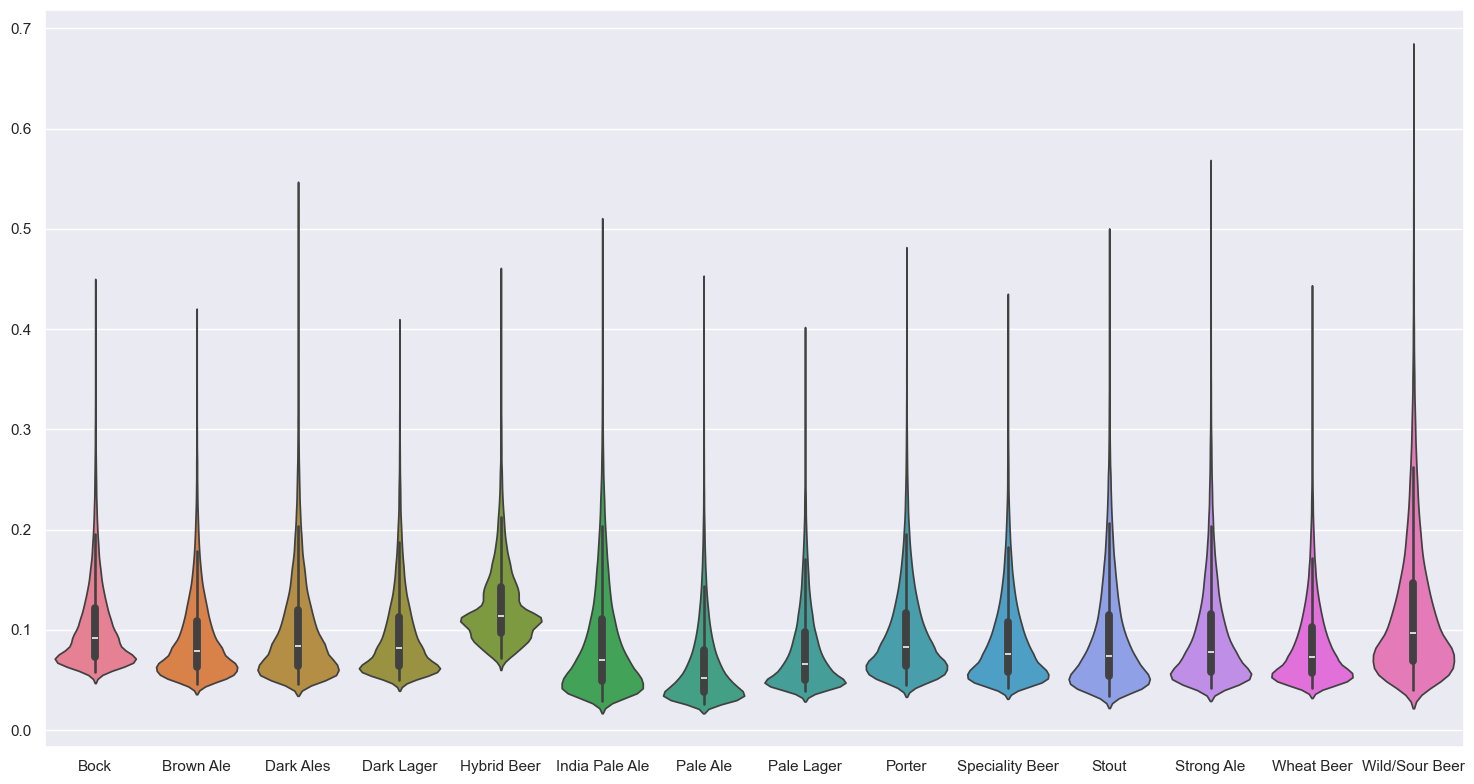

In [453]:
plt.figure(figsize=(15,8))
sns.violinplot(df_prime_local_knowledge.iloc[:,1:].replace(0,np.nan))
plt.tight_layout()
plt.show()

<u style="background-color:red;">Interpretation:</u> : This plot shows the distribution of *local knowledge* for each of beer style. It highlights the difficulty to enter the beer style as the lowest *local knowledge* reached varies such as the gap between Hybrid Beer and IPA. It's mainly due to the number of beers available for this style since a beer from a small beer style would provide more local knowledge than one in a big beer style. Moreover it also highlights the difficulty to reach high level of *local knowledge* in the different beer styles (find cause)

# Experts

In [454]:
df_ba_user_beer_style_past_ratings, df_local_knowledge_quantile_expert = add_experts(df_local_knowledge, df_ba_user_beer_style_past_ratings,0.99)

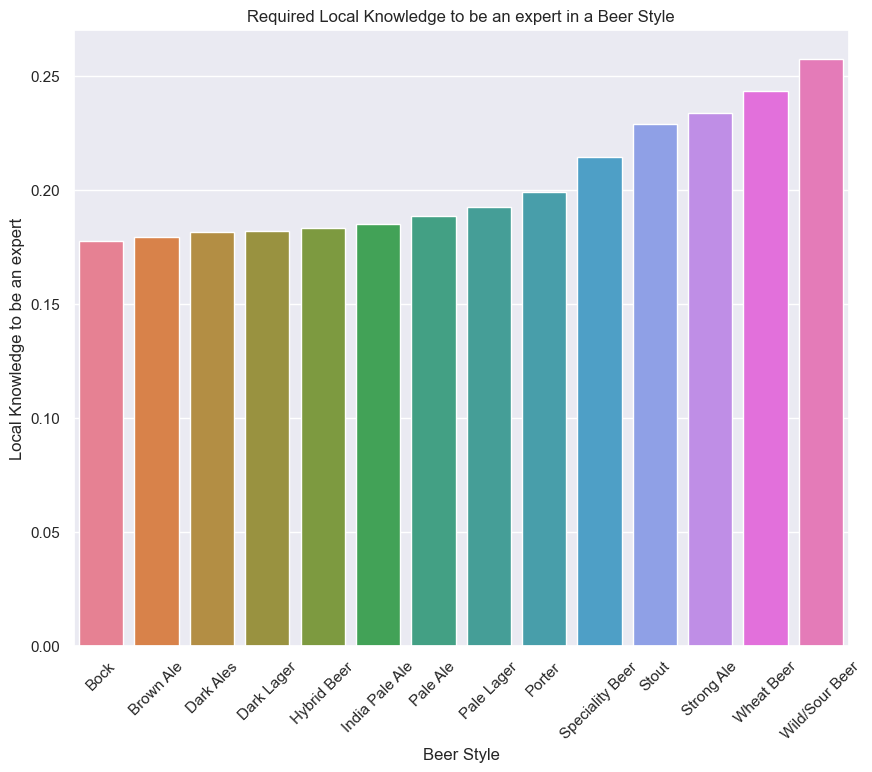

In [455]:
plt.figure(figsize=(10,8))
sns.barplot(x=df_local_knowledge_quantile_expert.index, y=df_local_knowledge_quantile_expert.sort_values(), hue=df_local_knowledge_quantile_expert.index)
plt.xticks(rotation=45)
plt.ylabel("Local Knowledge to be an expert")
plt.xlabel("Beer Style")
plt.title("Required Local Knowledge to be an expert in a Beer Style")
plt.show()

<u style="background-color:red;">Interpretation:</u> : Not all beer styles are equal in the required level of local knowledge to reach to be an *expert*. In fact the experts are only the user located at the tails for each style in the previous plot. The bigger the beer style, the lower the local knowledge to reach to be an expert : if there are more beers to rate then the knowledge gain per beer is smaller and the expert level of knowledge is smaller too. Nonetheless the more popular the beer style, the higher the local knowledge to reach to be an expert : if the beer style is more popular then more users tried it and therefore the top-1% is shifted upwards requiring more local knowledge. Example of IPA and Hybrid Beer having a similar local knowledge threshold because IPA is a big and popular beer style (88980 unique users for 41688 beers) while Hybrid Beer is a small and niche beer style (17408 unique users for 2642 beers).

In [456]:
df_ba_ratings[["user_id","beer_global_style"]].drop_duplicates().groupby("beer_global_style").count()

user_id
beer_global_style         
Bock                 29062
Brown Ale            36219
Dark Ales            44252
Dark Lager           35653
Hybrid Beer          17433
India Pale Ale       89006
Pale Ale             74729
Pale Lager           46935
Porter               40164
Speciality Beer      48107
Stout                65199
Strong Ale           53596
Wheat Beer           45749
Wild/Sour Beer       31646

In [457]:
df_ba_ratings[["beer_id","beer_global_style"]].drop_duplicates().groupby("beer_global_style").count()

beer_id
beer_global_style         
Bock                  4691
Brown Ale             9829
Dark Ales             9782
Dark Lager            7548
Hybrid Beer           2643
India Pale Ale       41701
Pale Ale             57094
Pale Lager           16041
Porter               10882
Speciality Beer      13156
Stout                24416
Strong Ale           13588
Wheat Beer           12933
Wild/Sour Beer       15312

In [458]:
max_available_beer_per_day = df_ba_user_beer_style_past_ratings[max_columns+["date_day"]].groupby("date_day").max().reset_index()
max_available_beer_per_day.columns = ["date_day"] + df_local_knowledge_quantile_expert.index.to_list()
max_available_beer_per_day.iloc[:,1:] = max_available_beer_per_day.iloc[:,1:] * np.pow(df_local_knowledge_quantile_expert,3)
df_beer_required_to_be_expert_long = max_available_beer_per_day.melt(id_vars='date_day', var_name='Beer Style', value_name='Beers to be expert')

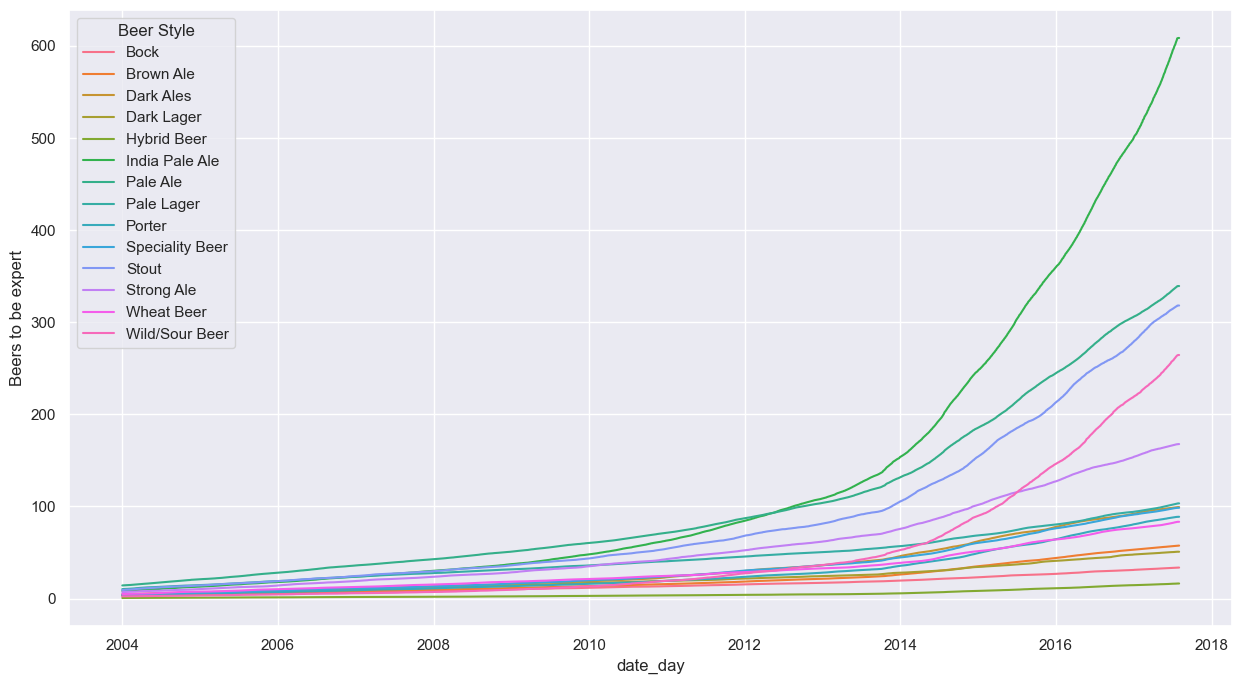

In [459]:
plt.figure(figsize=(15,8))
sns.lineplot(x=df_beer_required_to_be_expert_long["date_day"],y=df_beer_required_to_be_expert_long["Beers to be expert"], hue=df_beer_required_to_be_expert_long["Beer Style"])
plt.show()

<u style="background-color:red;">Interpretation:</u> : As the number of available beers per style grows, the required knowledge to be an expert follow a fairly similar trend.

In [460]:
expert_columns = [col for col in df_ba_user_beer_style_past_ratings.columns if "expert" in col]
n_unique_experts_per_style = df_ba_user_beer_style_past_ratings[expert_columns+["user_id"]].groupby("user_id").max().reset_index().iloc[:,1:].sum()

df_ba_user_beer_style_past_ratings.loc[:,"isExpert"] = df_ba_user_beer_style_past_ratings[expert_columns].sum(axis=1)
df_expert_users = df_ba_user_beer_style_past_ratings.loc[df_ba_user_beer_style_past_ratings["isExpert"] >= 1,["user_id"]+expert_columns].groupby("user_id").max().reset_index().merge(df_ba_users[["user_id","user_country"]], how="left", on="user_id")

In [461]:
df_expert_users = df_expert_users.merge(df_ba_users[["user_id","user_country_code"]], how="left", on="user_id")

In [462]:
df_count_exp = df_expert_users["user_country_code"].value_counts().reset_index()
df_count_exp["log_count"] = np.log(df_count_exp["count"])

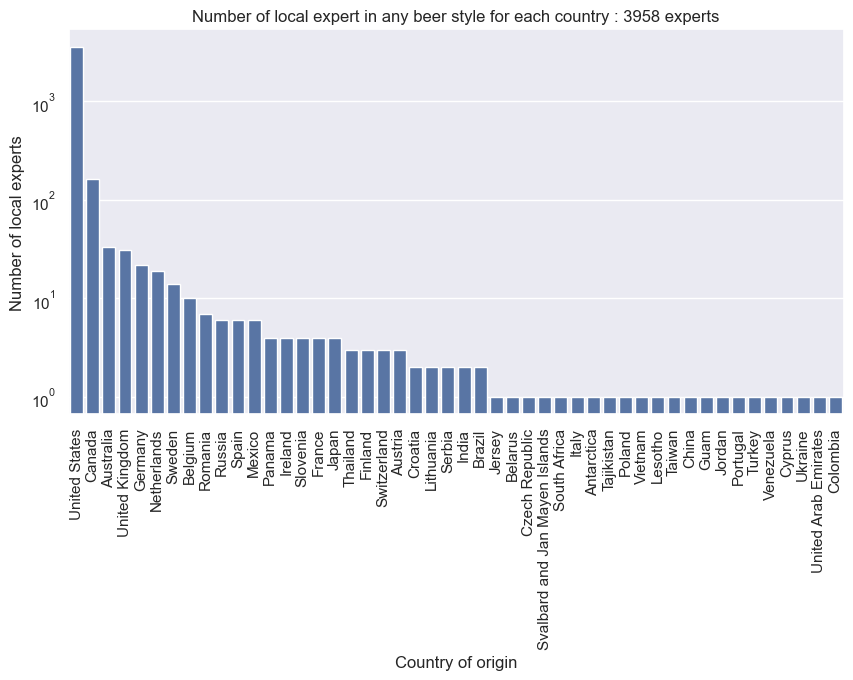

In [463]:
plt.figure(figsize=(10,5))
sns.barplot(df_expert_users["user_country"].value_counts())
plt.xticks(rotation=90)
plt.xlabel("Country of origin")
plt.ylabel("Number of local experts")
plt.title(f"Number of local expert in any beer style for each country : {df_expert_users["user_country"].value_counts().sum().item()} experts")
plt.yscale("log")
plt.show()

<u style="background-color:red;">Interpretation:</u> : With a massive domination, the United States are the clear leader of the world beer expertise. It is then followed by Canada before seeing a group of beer enthusiasts countries : United Kingdom, Australia, Sweden, Netherlands, Germany. We can also observe some smaller places where you can find an expert such as the incredible Svalbard and Jan Mayen Islands in the Artict Circle.

In [464]:
import plotly.io as pio
pio.renderers.default = 'browser'  # Use browser for rendering

In [465]:
fig = px.choropleth(
    df_count_exp,
    locations="user_country_code",
    color="log_count",
    hover_name="user_country_code",
    hover_data="count",
    color_continuous_scale=px.colors.sequential.Viridis
)


# Update layout for better visualization
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    geo=dict(showframe=False, showcoastlines=True, projection_type='mercator')
)

# Display the map
fig.show()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of t

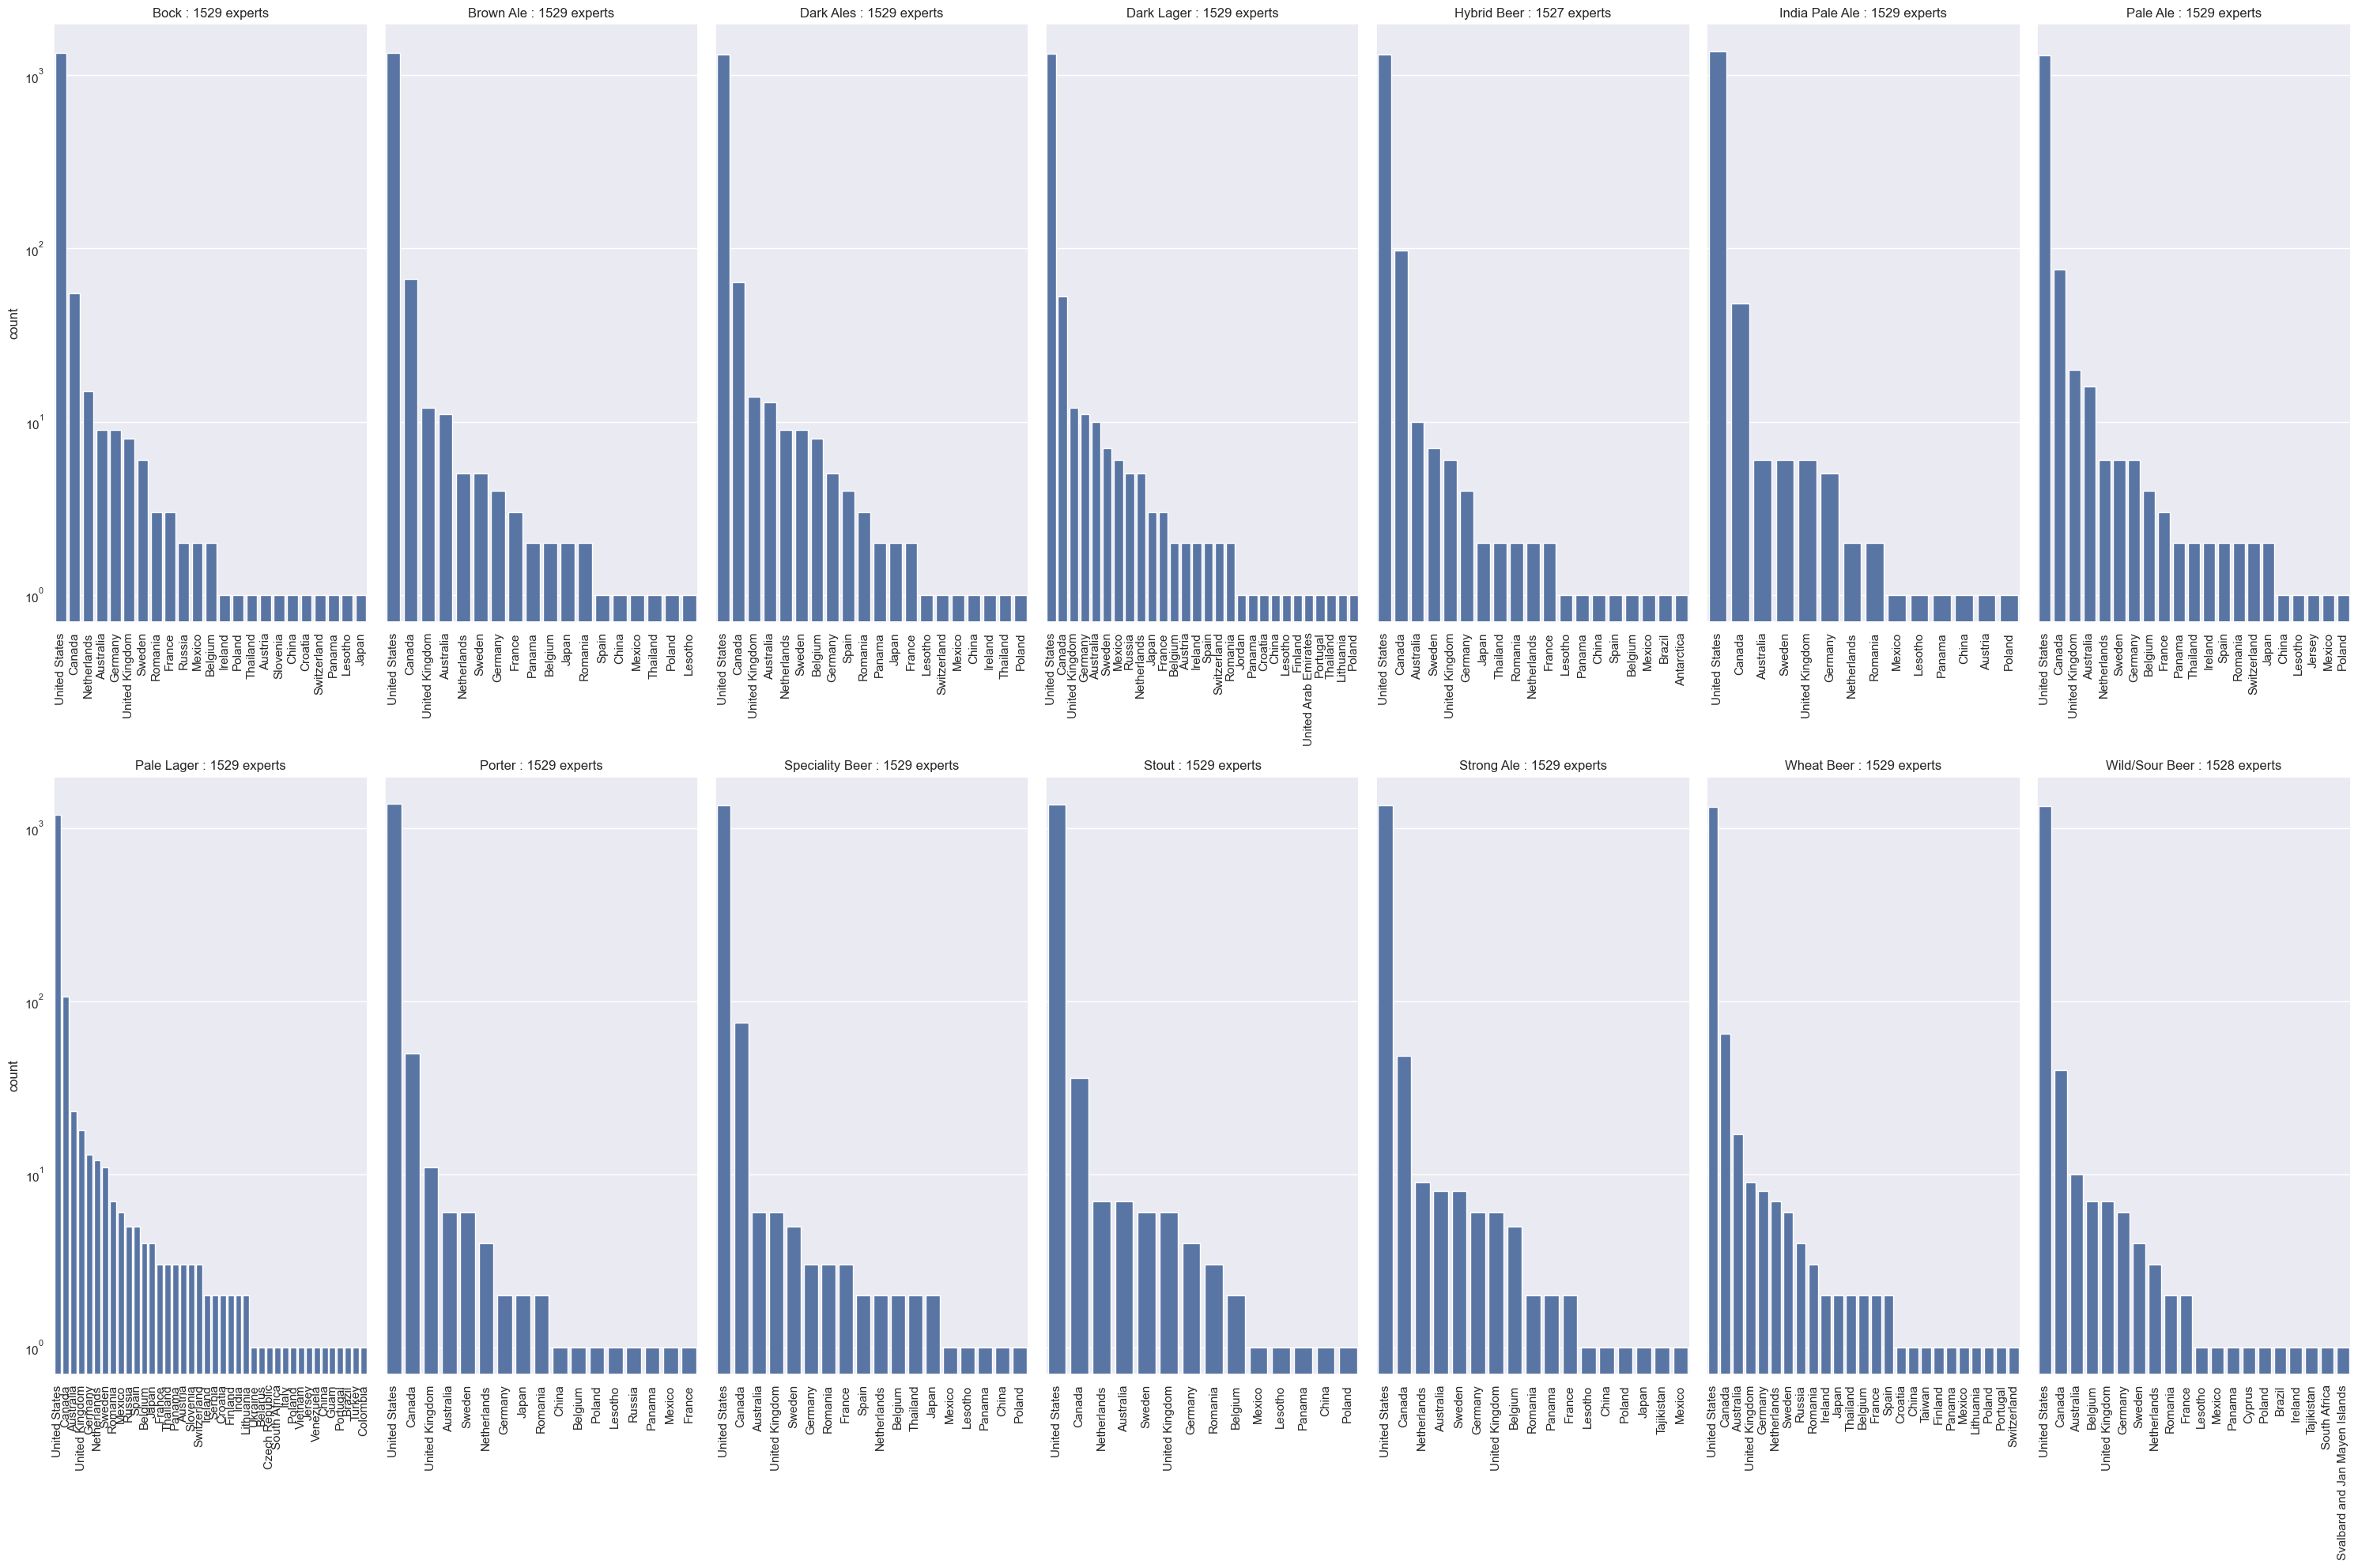

In [466]:
fig, axes = plt.subplots(2,7,figsize=(30,20),sharey=True)
for col_idx, col in enumerate(expert_columns):
    sns.barplot(df_expert_users[df_expert_users[col] == 1]["user_country"].value_counts(), ax=axes[col_idx//7,col_idx%7])
    #axes[col_idx//7,col_idx%7].set_xticklabels(rotation=90)
    axes[col_idx//7,col_idx%7].set_xticklabels(axes[col_idx//7,col_idx%7].get_xticklabels(), rotation=90)
    axes[col_idx//7,col_idx%7].set_xlabel("")
    #plt.ylabel(f"Number of local experts in {col.split("_")[0]}")
    axes[col_idx//7,col_idx%7].set_title(f"{col.split("_")[0]} : {df_expert_users[col].sum()} experts")
    axes[col_idx//7,col_idx%7].set_yscale("log")

plt.tight_layout()
plt.show()

<u style="background-color:red;">Interpretation:</u> : United States, Canada, United Kingdom and Australia are the leading quartet for each beer style. However there are some interesting surprises in the following countries : ...

In [467]:
n_unique_experts_per_style.sort_values()

Hybrid Beer_expert        1527
Wild/Sour Beer_expert     1528
Bock_expert               1529
Brown Ale_expert          1529
Dark Ales_expert          1529
Dark Lager_expert         1529
India Pale Ale_expert     1529
Pale Ale_expert           1529
Pale Lager_expert         1529
Porter_expert             1529
Speciality Beer_expert    1529
Stout_expert              1529
Strong Ale_expert         1529
Wheat Beer_expert         1529
dtype: int64

In [468]:
df_ba_user_beer_style_past_ratings['date_month'] = pd.to_datetime(df_ba_ratings['date'], unit="s").dt.to_period("M").dt.start_time
df_ba_user_beer_style_past_ratings['date_quarter'] = pd.to_datetime(df_ba_ratings['date'], unit="s").dt.to_period("Q").dt.start_time

In [469]:
df_expert_per_day = df_ba_user_beer_style_past_ratings[expert_columns+["date_month","user_id"]].groupby(["user_id","date_month"]).max().reset_index().iloc[:,1:].groupby("date_month").sum().reset_index()
df_expert_per_day_long = df_expert_per_day.melt(id_vars='date_month', var_name='Beer Style', value_name='Number of expert ratings')

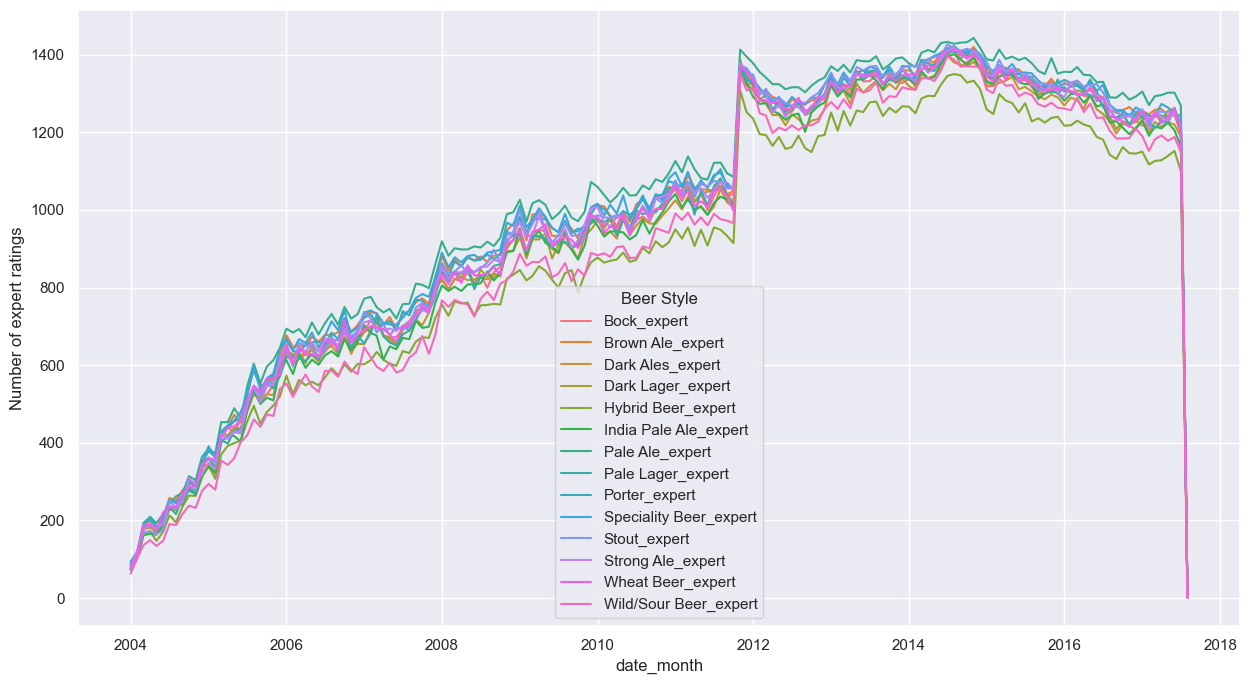

In [470]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df_expert_per_day_long,x="date_month",y='Number of expert ratings', hue="Beer Style")
plt.show()

<u style="background-color:red;">Interpretation:</u> :

In [471]:
df_expert_ratings = df_ba_user_beer_style_past_ratings[expert_columns+["date_day","user_id","beer_id"]].groupby(["user_id","date_day"]).max().reset_index().merge(df_ba_ratings[["user_id","date_day","beer_global_style","rating"]], how="inner", on=["user_id","date_day"])
df_to_plots = []
TOP_K_BEERS_THRESH = 100
for style in expert_columns:
    beer_rated_by_experts = df_expert_ratings[(df_expert_ratings[style] == 1)]["beer_id"].unique()
    top_k_beers = df_ba_ratings[(df_ba_ratings["beer_global_style"] == style.split("_")[0]) & (df_ba_ratings["beer_id"].isin(beer_rated_by_experts))][["rating","beer_id"]].groupby("beer_id").count().reset_index().sort_values(by="rating",ascending=False).head(TOP_K_BEERS_THRESH)["beer_id"].to_numpy()
    df_same_beers = df_expert_ratings[(df_expert_ratings["beer_global_style"] == style.split("_")[0]) & (df_expert_ratings["beer_id"].isin(top_k_beers))]
    df_to_plots.append(df_same_beers[["beer_global_style","rating",style]].rename(columns={style:"expert"}))
df_to_barplot = pd.concat(df_to_plots,axis=0)

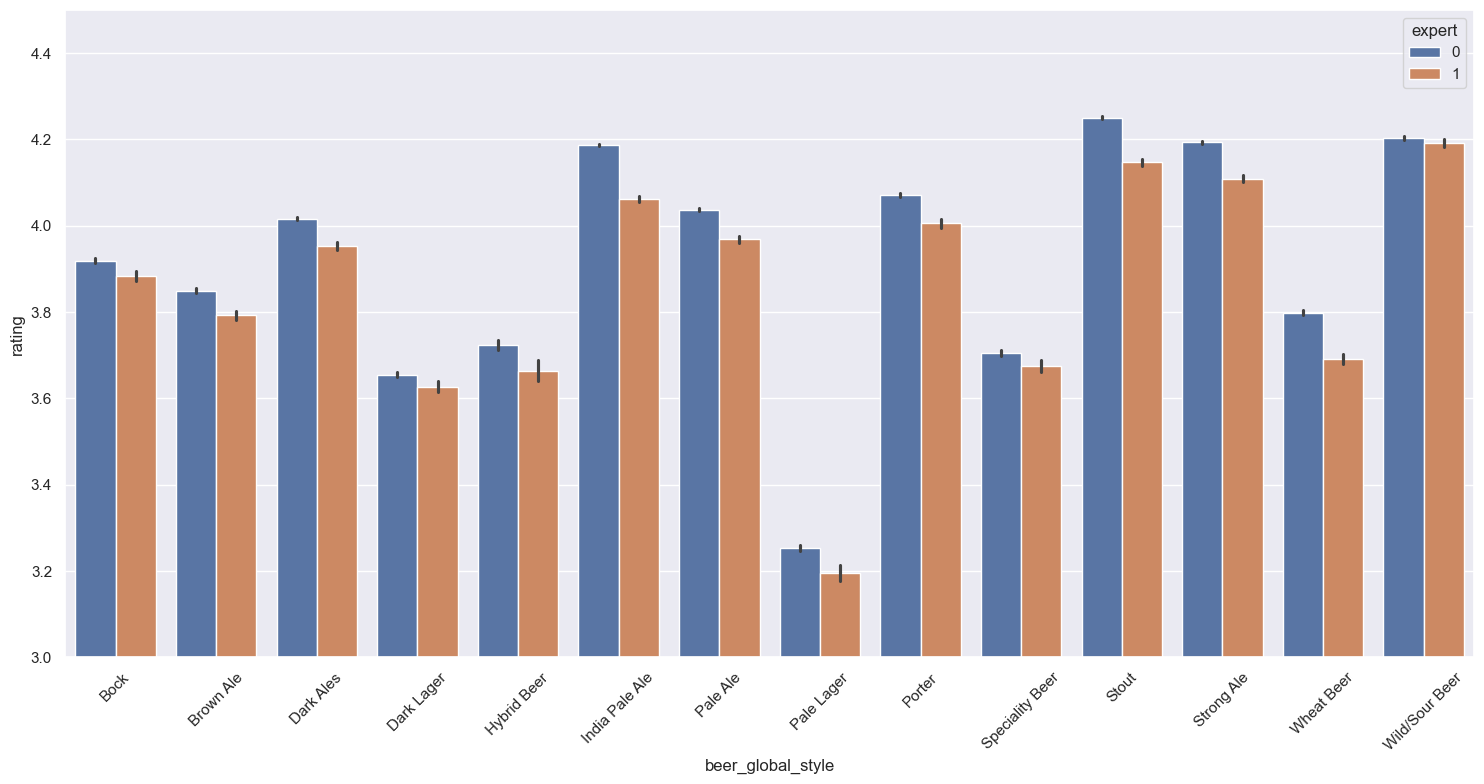

In [472]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_to_barplot,x="beer_global_style", y="rating", hue="expert")
#plt.errorbar(x=df_to_show["beer_global_style"], y=df_to_show["rating"]["mean"], yerr=df_to_show["rating"]["sem"], fmt="none", c="black", capsize=5)
plt.xticks(rotation=45)
plt.ylim([3,4.5])
plt.tight_layout()
plt.show()

<u style="background-color:red;">Interpretation:</u> :

In [473]:
df_experts = df_ba_user_beer_style_past_ratings[expert_columns+["user_id","date_day"]]
df_ba_ratings = df_ba_ratings.dropna()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1418684443.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1418684443.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1418684443.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

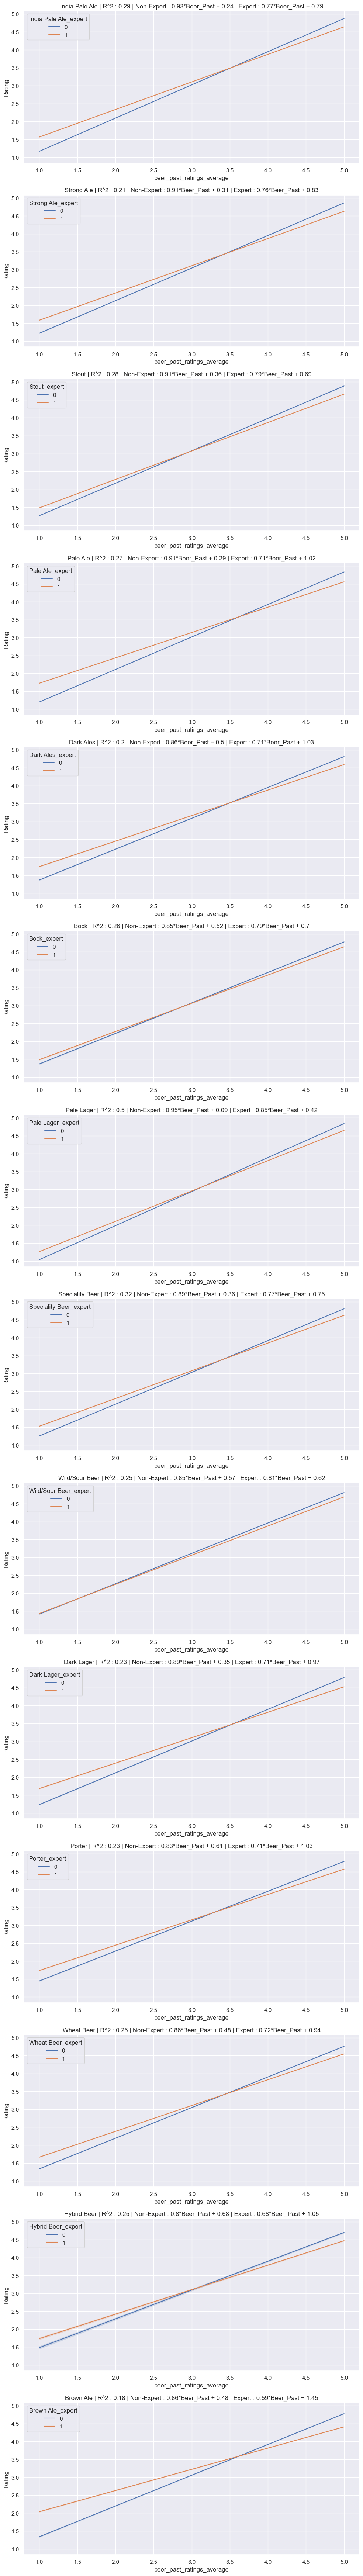

In [474]:
fig, axes = plt.subplots(14,1,figsize=(10,70),sharey=True)

for style_idx, beer_style in enumerate(df_ba_ratings["beer_global_style"].unique()):

    df_study = df_ba_ratings[df_ba_ratings["beer_global_style"] == beer_style][["user_id","date_day","beer_past_ratings_average","rating"]].merge(df_experts, how="left", on=["user_id","date_day"])
    X = df_study[[beer_style+"_expert", 'beer_past_ratings_average']]
    X.loc[:,"interaction"] = X[beer_style+"_expert"] * X["beer_past_ratings_average"]
    X.loc[:,"intercept"] = 1
    y = df_study['rating']
    reg = sm.OLS(y, X).fit()
    df_line = pd.DataFrame({beer_style+"_expert":[0,0,1,1],'beer_past_ratings_average':[1.0,5.0,1.0,5.0],'interaction':[0,0,1.0,5.0],'intercept':[1,1,1,1]})
    #df_line = pd.DataFrame({beer_style+"_expert":[0,0,1,1],'beer_past_ratings_average':[1.0,5.0,1.0,5.0],'interaction':[0,0,1.0,5.0]})

    prediction = reg.get_prediction(df_line)
    predicted_mean = prediction.predicted_mean
    conf_int = prediction.conf_int()

    df_line["predicted_rating"] = predicted_mean
    df_line["ci_lower"] = conf_int[:, 0]
    df_line["ci_upper"] = conf_int[:, 1]

    sns.lineplot(data = df_line, x = "beer_past_ratings_average", y = "predicted_rating", hue = beer_style+"_expert", legend=True, ax=axes[style_idx])
    axes[style_idx].set_title(f"{beer_style} | R^2 : {round(reg.rsquared.item(),2)} | Non-Expert : {round(reg.params["beer_past_ratings_average"],2)}*Beer_Past + {round(reg.params["intercept"],2)} | Expert : {round(reg.params["beer_past_ratings_average"] + reg.params["interaction"],2)}*Beer_Past + {round(reg.params["intercept"] + reg.params[beer_style+"_expert"],2)}")
    #axes[style_idx].set_title(f"{beer_style} | R^2 : {round(reg.rsquared.item(),2)} | Non-Expert : {round(reg.params["beer_past_ratings_average"],2)}*Beer_Past | Expert : {round(reg.params["beer_past_ratings_average"] + reg.params["interaction"],2)}*Beer_Past + {round(reg.params[beer_style+"_expert"],2)}")
    axes[style_idx].set_ylabel("Rating")

    for expert in df_line[beer_style+"_expert"].unique():
        expert_data = df_line[df_line[beer_style+"_expert"] == expert]
        axes[style_idx].fill_between(
            expert_data["beer_past_ratings_average"], 
            expert_data["ci_lower"], 
            expert_data["ci_upper"], 
            alpha=0.2  # Adjust transparency of the shaded region
        )
plt.tight_layout()
plt.show()

<u style="background-color:red;">Interpretation:</u> :

In [475]:
df_expertise = df_expert_users.iloc[:,:-2].melt(id_vars="user_id",var_name="expertise",value_name="val")

In [476]:
df_expertise.drop(df_expertise[df_expertise["val"] == 0].index, axis=0, inplace=True)

In [477]:
df_expertise.loc[:,"expertise"] = df_expertise["expertise"].apply(lambda x: x.split("_")[0])

In [478]:
df_expertise.drop("val",axis=1,inplace=True)

In [479]:
df_co_experts_count = df_expertise.groupby("user_id").count().reset_index()

In [480]:
co_experts = df_co_experts_count[df_co_experts_count["expertise"] > 1]["user_id"]

In [481]:
df_coexpertise = df_expertise[df_expertise["user_id"].isin(co_experts)].merge(df_expertise[df_expertise["user_id"].isin(co_experts)], on="user_id", how="left", suffixes=["_a","_b"])

In [482]:
df_coexpertise.drop(df_coexpertise[df_coexpertise["expertise_a"] == df_coexpertise["expertise_b"]].index,axis=0,inplace=True)

In [483]:
df_soloexpertise = df_expertise[~df_expertise["user_id"].isin(co_experts)]

In [484]:
df_soloexpertise.rename(columns={"expertise":"expertise_a"},inplace=True)

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/901004683.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [485]:
df_soloexpertise.loc[:,"expertise_b"] = df_soloexpertise["expertise_a"]

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/246054117.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [486]:
df_final_expertise = pd.concat([df_soloexpertise,df_coexpertise],axis=0)

In [487]:
df_final_expertise.groupby(["expertise_a","expertise_b"]).count().reset_index().to_csv("./coexpertise.csv",index=False)

In [488]:
df_coexpertise_count = df_final_expertise.groupby(["expertise_a","expertise_b"]).count().reset_index()

In [489]:
df_coexpertise_count.loc[df_coexpertise_count[["expertise_a","user_id"]].groupby("expertise_a").idxmax().reset_index()["user_id"]].to_csv("./coexpertise_bis.csv",index=False)

In [490]:
df_final_expertise.to_csv("./coexpertise.csv",index=False)

# Graphical Approach of experts

## Shell Layout with nodes as expertise kind and beer styles

In [491]:
import networkx as nx
import community as community_louvain

MIN_EXPERT = 70
SIZE_STYLE = 1000
SIZE_EXPERT_MIN = 500

In [492]:
G = nx.Graph()

styles = df_ba_ratings["beer_global_style"].unique()
styles.sort()

styles_total = df_expert_users.iloc[:,1:-2].sum().to_dict()

user_expertise = dict()

for row in df_expert_users.iterrows():
    expertise = []
    for style_idx, style in enumerate(styles):
        if row[1][style_idx + 1] == 1:
            expertise.append(style)
    user_expertise[row[1][0]] = expertise

expertise_kinds = []
for val in user_expertise.values():
    if val not in expertise_kinds:
        expertise_kinds.append(val)

edge_sizes = []
for i, expertise in enumerate(expertise_kinds):
    size = list(user_expertise.values()).count(expertise)
    if size >= MIN_EXPERT and len(expertise) >= 2:
        G.add_node(str(i))
        for style in expertise:
            G.add_edge(style,str(i))
            expert_share = 100 * (size / styles_total[style+"_expert"])
            edge_sizes.append(expert_share)

colors = ["red","green","blue","orange","purple","cyan","magenta","yellow","pink","lime","teal","brown","gray","olive"]
kind_to_color_bis = {styles[i]:colors[i] for i in range(len(styles))}

edge_colors = []
for u,v in G.edges():
    if u in styles:
        edge_colors.append(kind_to_color_bis[u])
    else:
        edge_colors.append(kind_to_color_bis[v])

node_sizes = []
node_colors = []
experts = []
for node in G.nodes():
    if node in styles:
        node_sizes.append(SIZE_STYLE)
        node_colors.append(kind_to_color_bis[node])
    else:
        experts.append(node)
        expertises = expertise_kinds[int(node)]
        node_sizes.append(SIZE_EXPERT_MIN + list(user_expertise.values()).count(expertises))
        node_colors.append("black")

shells = [styles, experts]
pos = nx.shell_layout(G, shells)

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/4011270081.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/4011270081.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



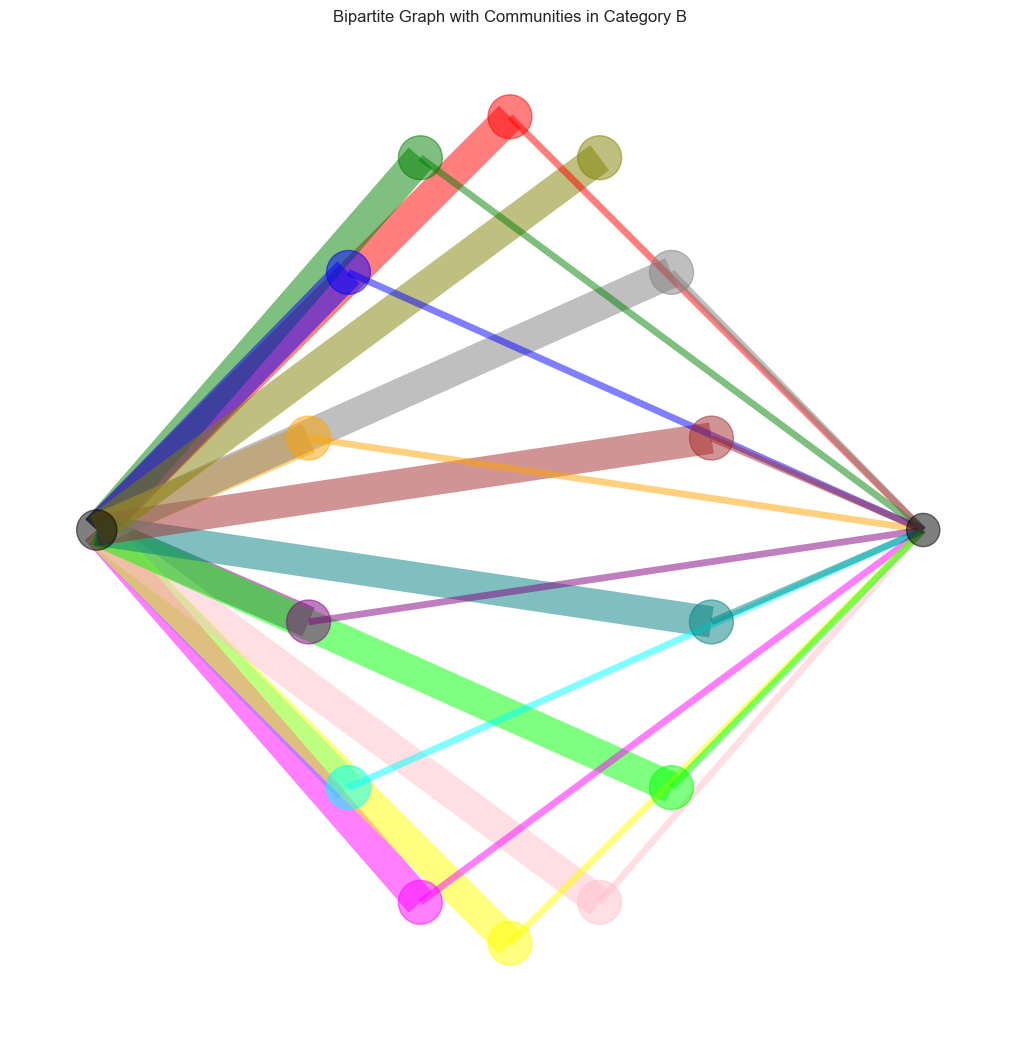

In [493]:
plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color=edge_colors,
    width=edge_sizes,
    alpha=0.5
)
plt.title("Bipartite Graph with Communities in Category B")
plt.show()

## Spring layout with nodes as users and beer styles

In [494]:
G_bis = nx.Graph()

styles = df_ba_ratings["beer_global_style"].unique()
styles.sort()

G_bis.add_nodes_from(styles)
G_bis.add_nodes_from(df_expert_users["user_id"])

df_expert_users_renamed = df_expert_users.rename(columns={style+"_expert":style for style in styles}).iloc[:,:-2]
df_edges = df_expert_users_renamed.melt(id_vars="user_id",var_name="style",value_name="edge")
G_bis.add_edges_from(df_edges[df_edges["edge"] == 1][["user_id","style"]].values)

nodes_to_remove = [node for node in G_bis.nodes() if G_bis.degree(node) == 1]

G_bis.remove_nodes_from(nodes_to_remove)

node_sizes = []
node_colors = []
for node in G_bis.nodes():
    if node in styles:
        node_sizes.append(500)
        node_colors.append("red")
    else:
        node_colors.append("blue")
        node_sizes.append(10)

user_nodes = [node for node in G_bis.nodes() if node in df_expert_users_renamed["user_id"]]
style_nodes = [node for node in G_bis.nodes() if node in styles]

all_pos = nx.spring_layout(G_bis, seed=42)

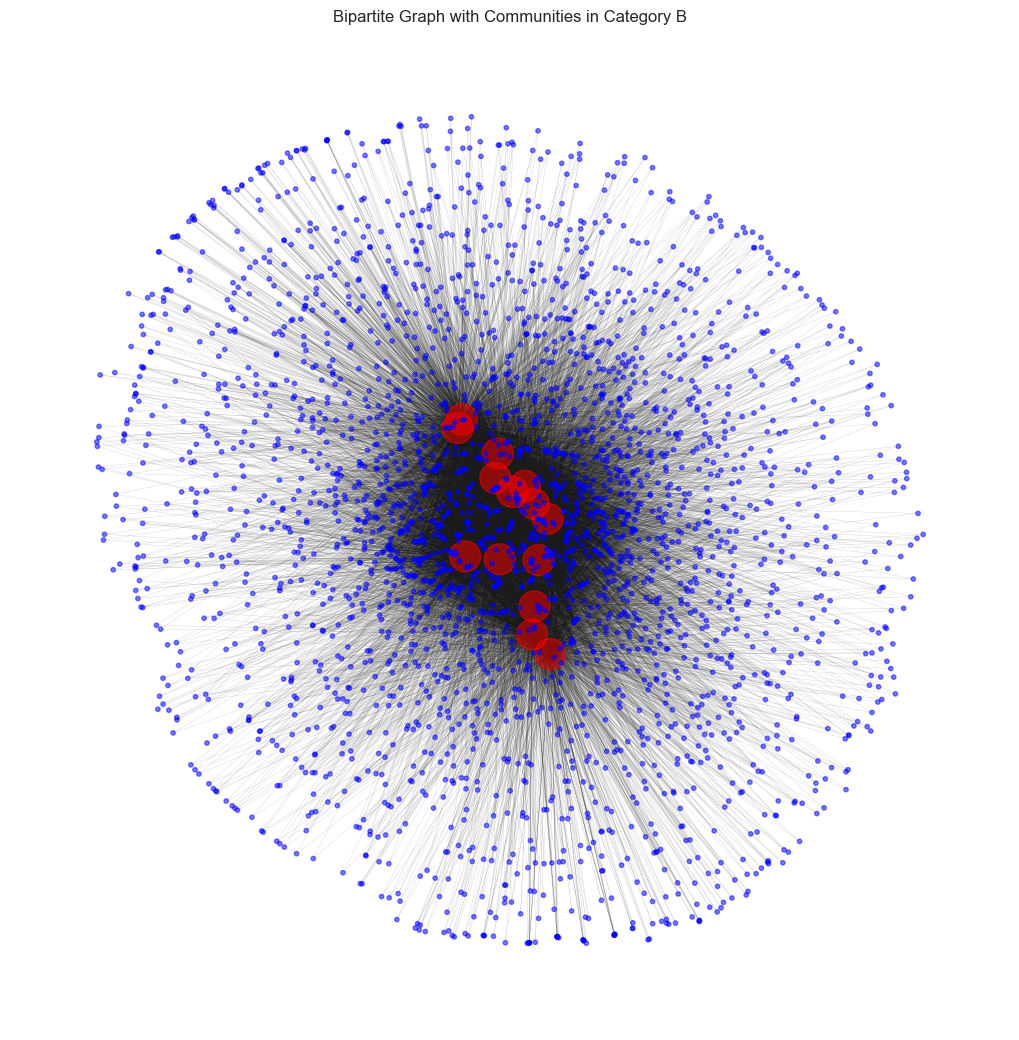

In [495]:
plt.figure(figsize=(10, 10))
nx.draw(
    G_bis,
    all_pos,
    node_size=node_sizes,
    node_color=node_colors,
    width=0.1,
    alpha=0.5
)
plt.title("Bipartite Graph with Communities in Category B")
plt.show()

# Rate Beer

In [377]:
df_rb_user_beer_style_past_ratings = pd.read_csv("../data/rate_beer/user_beer_style_past_ratings.csv")
df_rb_ratings = pd.read_csv("../data/rate_beer/ratings.csv")

In [378]:
df_rb_ratings.loc[:,"user_beer_style_past_ratings_count"] = df_rb_ratings["user_beer_style_past_ratings_count"] - 1
df_rb_ratings.loc[df_rb_ratings["user_beer_style_past_ratings_count"] == 0,"user_beer_style_past_ratings_average"] = np.nan
df_rb_ratings['date_day'] = pd.to_datetime(df_rb_ratings['date'], unit="s").dt.round('D')
df_rb_ratings.drop(df_rb_ratings[df_rb_ratings["beer_global_style"] == "Low Alcohol Beer"].index, axis=0, inplace=True)

#To preprocess once and for all
df_rb_user_beer_style_past_ratings['date_day'] = pd.to_datetime(df_rb_user_beer_style_past_ratings['date'], unit="s").dt.round('D')

In [379]:
df_current_beer_per_style = number_of_beer_per_style(df_rb_ratings)
df_current_beer_per_style.drop(df_current_beer_per_style[df_current_beer_per_style["date_day"] < "2004-01-01"].index, axis=0, inplace=True)

In [380]:
df_rb_ratings['month']   = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('M').dt.start_time
df_rb_ratings = remove_before_month(df_rb_ratings, '2004-01')

In [381]:
df_rb_user_beer_style_past_ratings = df_rb_user_beer_style_past_ratings[df_rb_user_beer_style_past_ratings["user_id"].isin(df_rb_ratings["user_id"].drop_duplicates())]

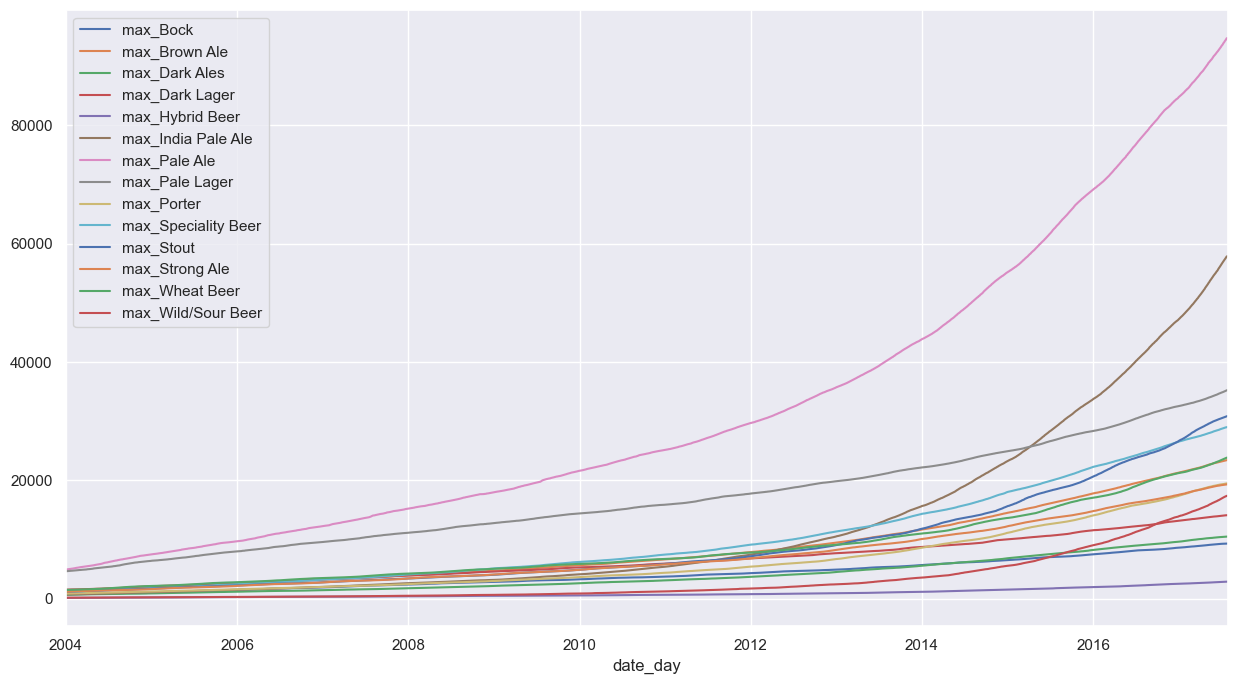

In [368]:
df_current_beer_per_style.plot(x="date_day",grid=True,figsize=(15,8))
plt.show()

In [382]:
average_columns = [col for col in df_rb_user_beer_style_past_ratings.columns if "average" in col]
count_columns = [col for col in df_rb_user_beer_style_past_ratings.columns if "count" in col]
max_columns = [col for col in df_current_beer_per_style.columns if "max" in col]

In [383]:
df_rb_user_beer_style_past_ratings = add_global_knowledge(df_current_beer_per_style, df_rb_user_beer_style_past_ratings, count_columns)
df_rb_user_beer_style_past_ratings, df_local_knowledge = add_local_knowledge(df_current_beer_per_style, df_rb_user_beer_style_past_ratings, max_columns, count_columns)

df_knowledge = df_rb_user_beer_style_past_ratings[["user_id","date_day","beer_id","global_knowledge","local_knowledge","style_tried"]]
df_knowledge.loc[:,"knowledge"] = (df_knowledge["global_knowledge"]+df_knowledge["local_knowledge"])/2

df_knowledge = df_knowledge.drop(df_knowledge[df_knowledge["local_knowledge"] == 0].index, axis=0)

df_prime_knowledge = df_knowledge[["user_id","global_knowledge","local_knowledge","knowledge"]].groupby("user_id").max().reset_index()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1715063475.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



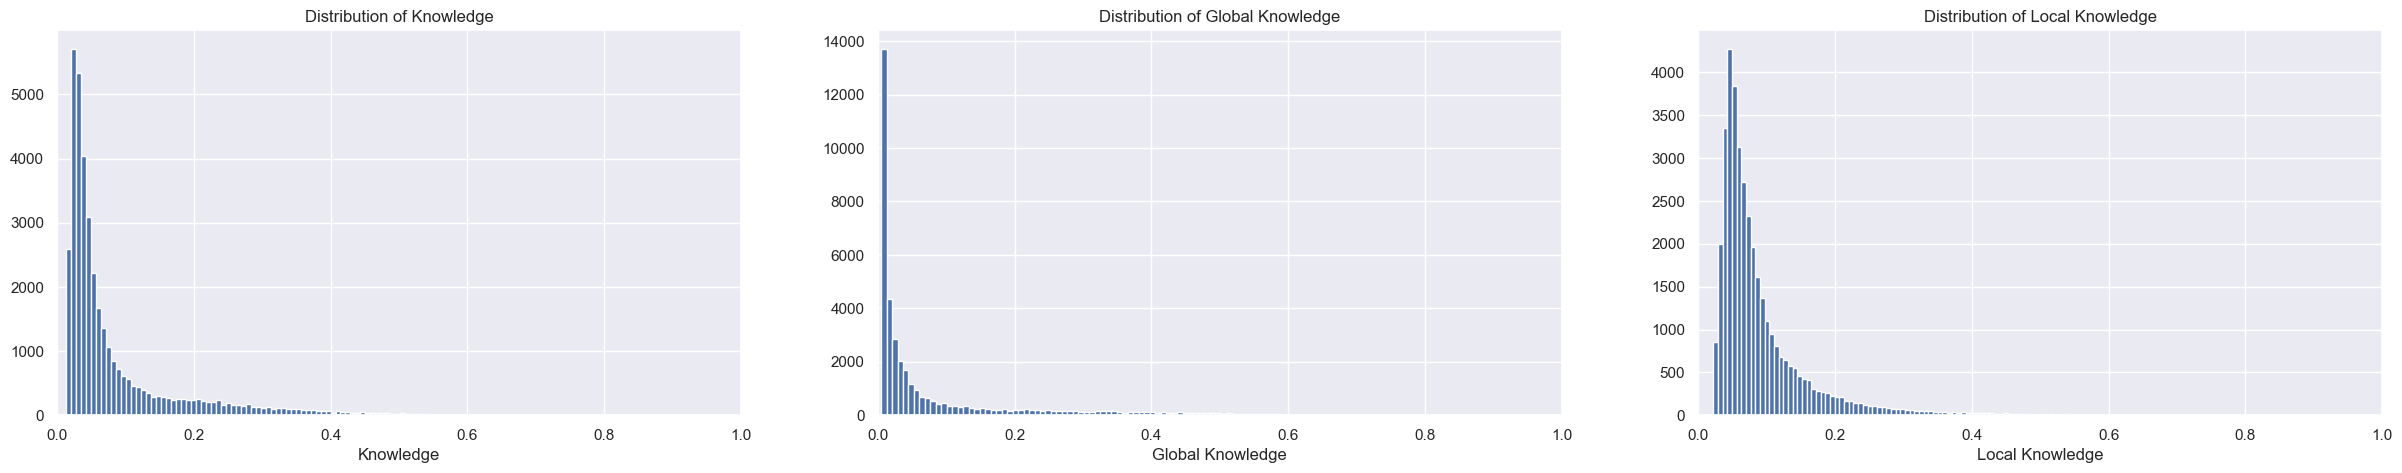

In [384]:
plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
df_prime_knowledge["knowledge"].hist(bins=100)
plt.title("Distribution of Knowledge")
plt.xlabel("Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,2)
df_prime_knowledge["global_knowledge"].hist(bins=100)
plt.title("Distribution of Global Knowledge")
plt.xlabel("Global Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,3)
df_prime_knowledge["local_knowledge"].hist(bins=100)
plt.title("Distribution of Local Knowledge")
plt.xlabel("Local Knowledge")
plt.xlim([0,1])

plt.show()

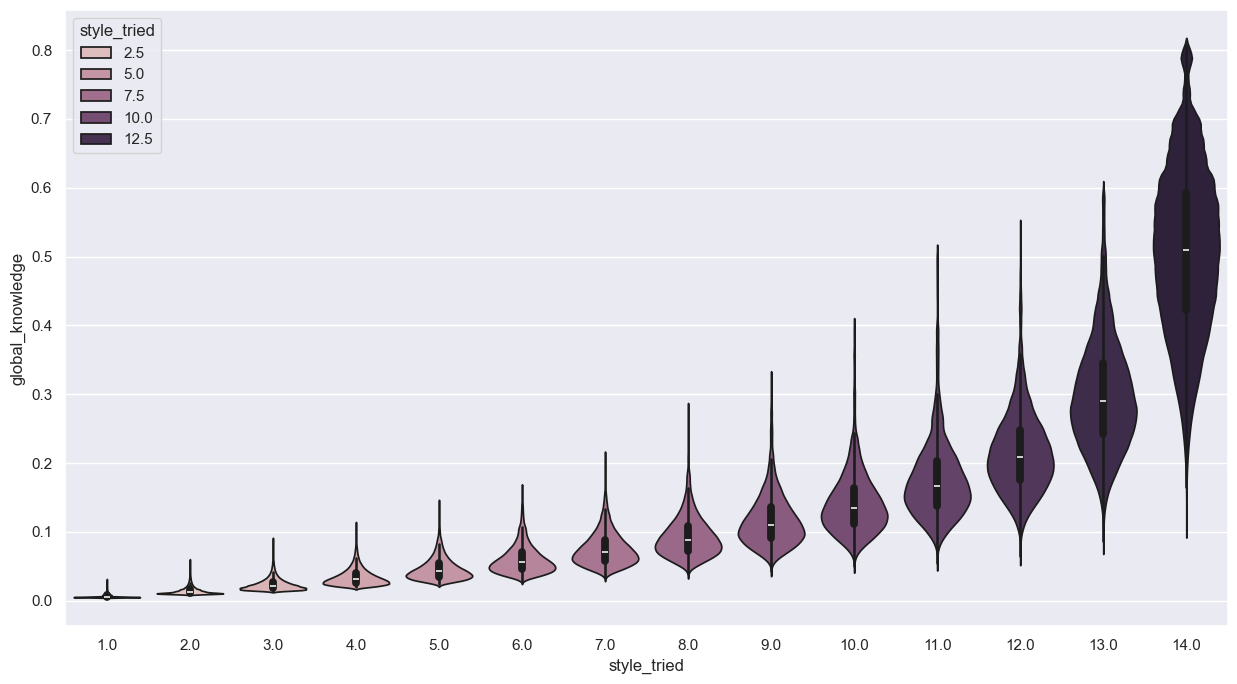

In [385]:
plt.figure(figsize=(15,8))
sns.violinplot(x=df_knowledge["style_tried"],y=df_knowledge["global_knowledge"],hue=df_knowledge["style_tried"])
plt.show()

In [410]:
df_prime_local_knowledge = df_local_knowledge.iloc[:,:-1].groupby("user_id").max().reset_index()

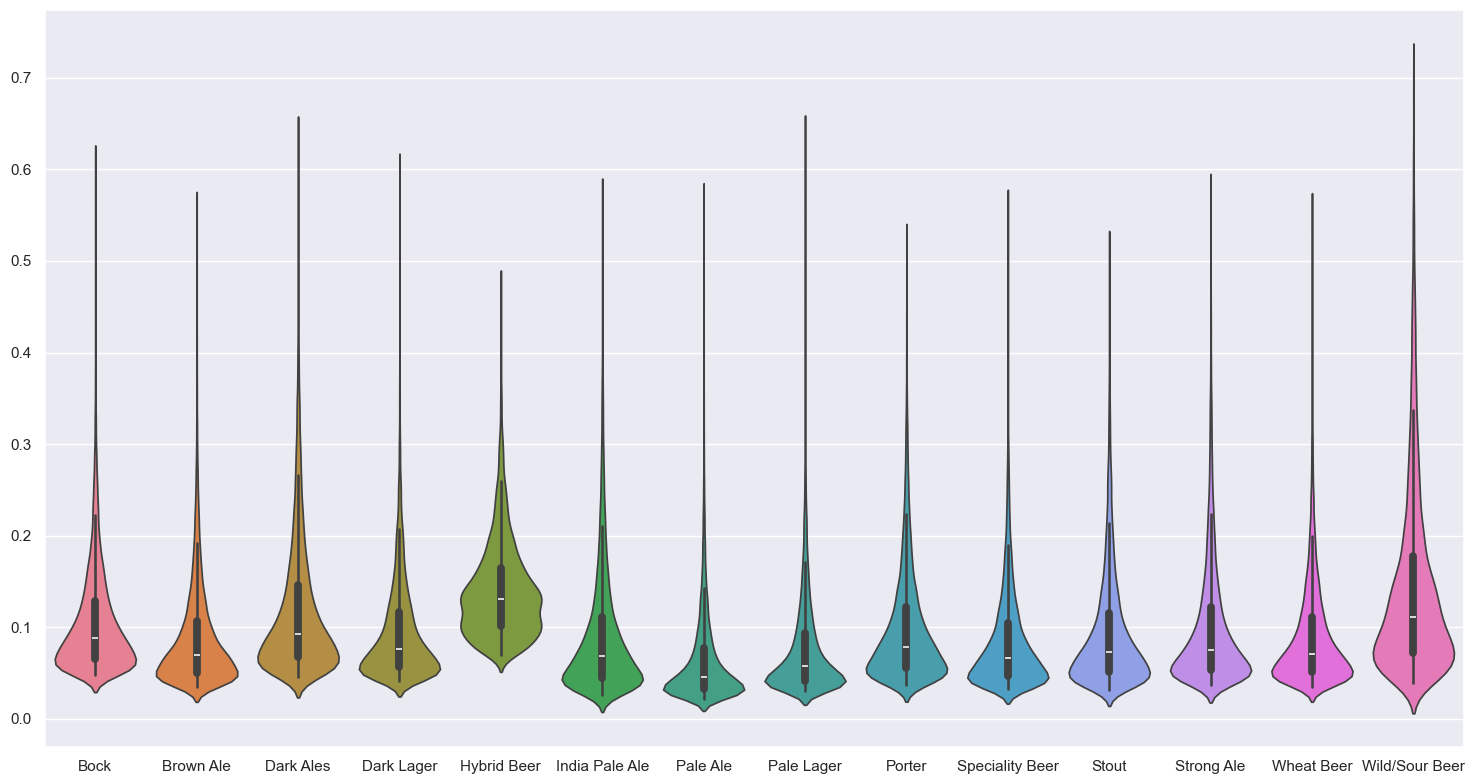

In [413]:
plt.figure(figsize=(15,8))
sns.violinplot(df_prime_local_knowledge.iloc[:,1:].replace(0,np.nan))
plt.tight_layout()
plt.show()

# Experts

In [414]:
df_rb_user_beer_style_past_ratings, df_local_knowledge_quantile_expert = add_experts(df_local_knowledge, df_rb_user_beer_style_past_ratings,0.99)

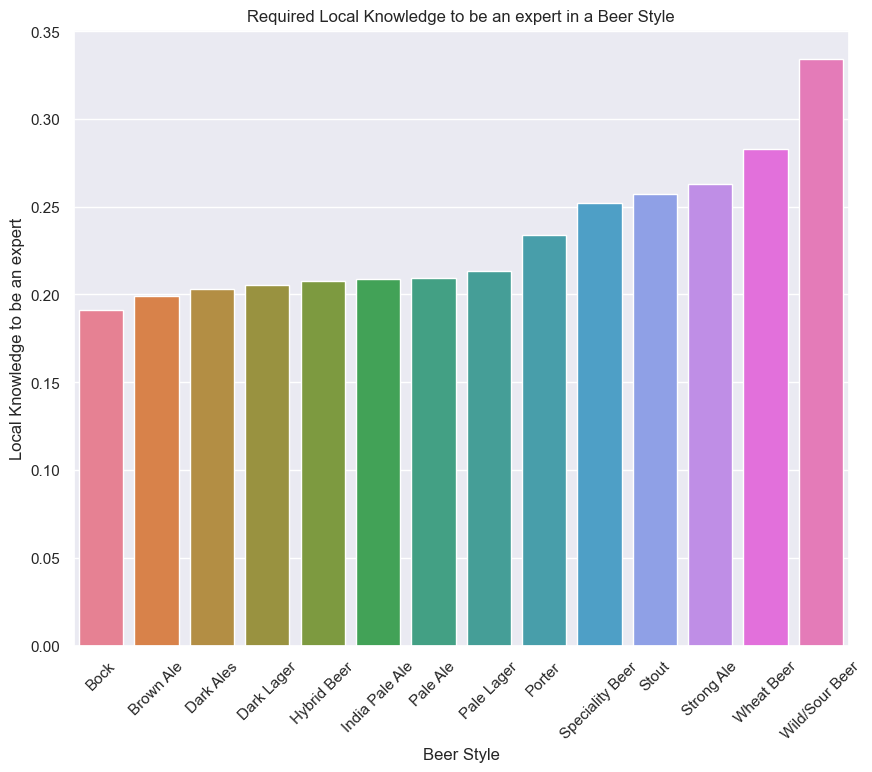

In [415]:
plt.figure(figsize=(10,8))
sns.barplot(x=df_local_knowledge_quantile_expert.index, y=df_local_knowledge_quantile_expert.sort_values(), hue=df_local_knowledge_quantile_expert.index)
plt.xticks(rotation=45)
plt.ylabel("Local Knowledge to be an expert")
plt.xlabel("Beer Style")
plt.title("Required Local Knowledge to be an expert in a Beer Style")
plt.show()

In [416]:
max_available_beer_per_day = df_rb_user_beer_style_past_ratings[max_columns+["date_day"]].groupby("date_day").max().reset_index()
max_available_beer_per_day.columns = ["date_day"] + df_local_knowledge_quantile_expert.index.to_list()
max_available_beer_per_day.iloc[:,1:] = max_available_beer_per_day.iloc[:,1:] * np.pow(df_local_knowledge_quantile_expert,3)
df_beer_required_to_be_expert_long = max_available_beer_per_day.melt(id_vars='date_day', var_name='Beer Style', value_name='Beers to be expert')

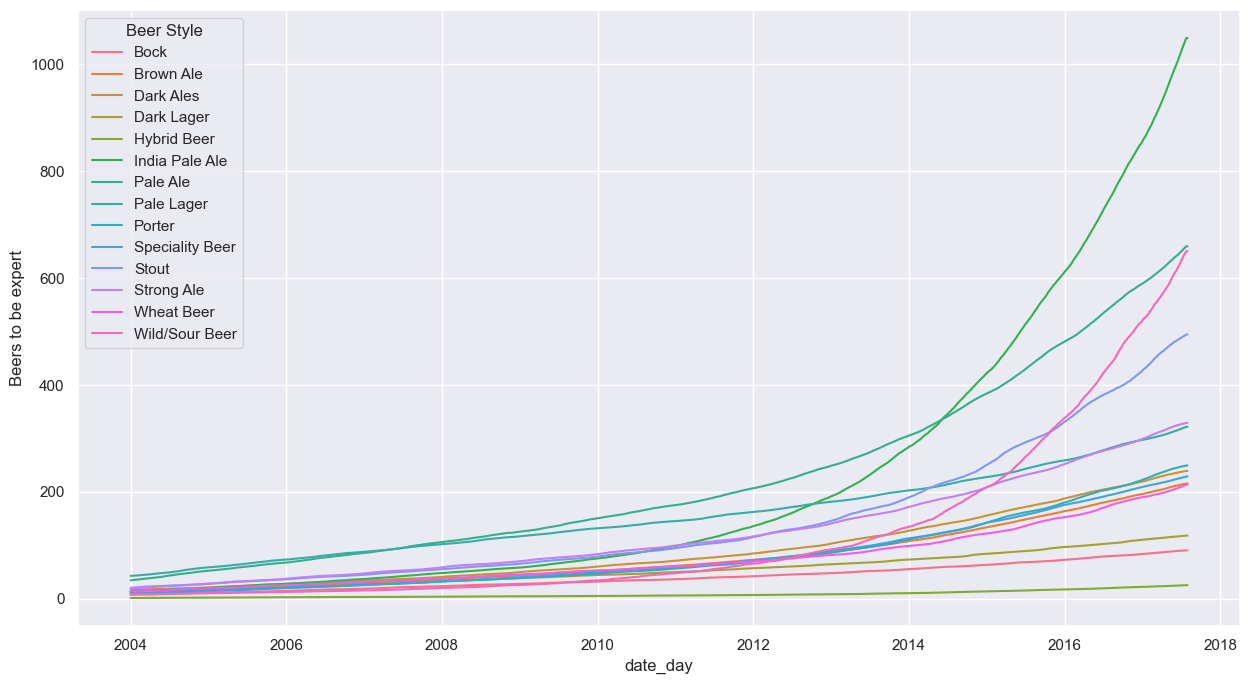

In [417]:
plt.figure(figsize=(15,8))
sns.lineplot(x=df_beer_required_to_be_expert_long["date_day"],y=df_beer_required_to_be_expert_long["Beers to be expert"], hue=df_beer_required_to_be_expert_long["Beer Style"])
plt.show()

In [418]:
expert_columns = [col for col in df_rb_user_beer_style_past_ratings.columns if "expert" in col]
n_unique_experts_per_style = df_rb_user_beer_style_past_ratings[expert_columns+["user_id"]].groupby("user_id").max().reset_index().iloc[:,1:].sum()

df_rb_user_beer_style_past_ratings.loc[:,"isExpert"] = df_rb_user_beer_style_past_ratings[expert_columns].sum(axis=1)
df_expert_users = df_rb_user_beer_style_past_ratings.loc[df_rb_user_beer_style_past_ratings["isExpert"] >= 1,["user_id"]+expert_columns].groupby("user_id").max().reset_index().merge(df_rb_users[["user_id","user_country"]], how="left", on="user_id")

In [419]:
df_expert_users = df_expert_users.merge(df_rb_users[["user_id","user_country_code"]], how="left", on="user_id")

In [420]:
df_count_exp = df_expert_users["user_country_code"].value_counts().reset_index()
df_count_exp["log_count"] = np.log(df_count_exp["count"])

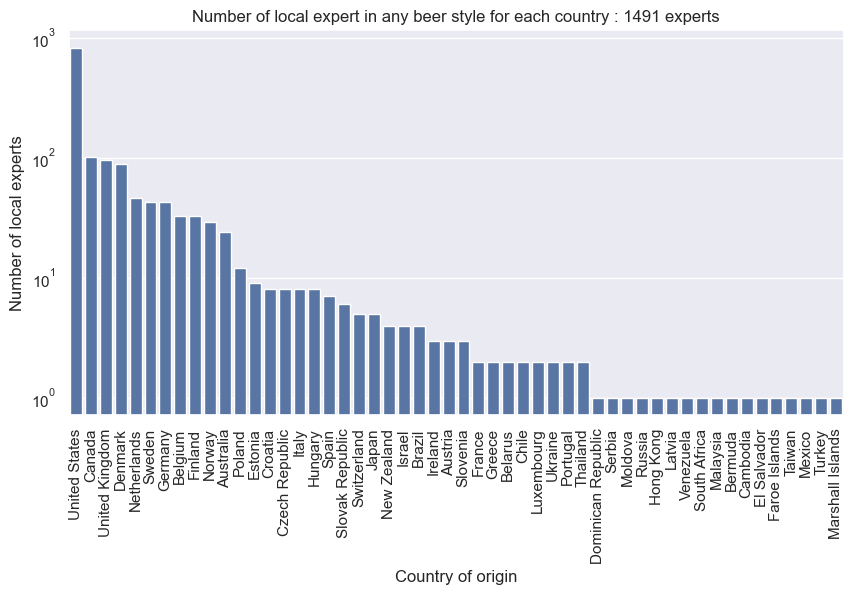

In [421]:
plt.figure(figsize=(10,5))
sns.barplot(df_expert_users["user_country"].value_counts())
plt.xticks(rotation=90)
plt.xlabel("Country of origin")
plt.ylabel("Number of local experts")
plt.title(f"Number of local expert in any beer style for each country : {df_expert_users["user_country"].value_counts().sum().item()} experts")
plt.yscale("log")
plt.show()

In [422]:
import plotly.io as pio
pio.renderers.default = 'browser'  # Use browser for rendering

In [423]:
fig = px.choropleth(
    df_count_exp,
    locations="user_country_code",
    color="log_count",
    hover_name="user_country_code",
    hover_data="count",
    color_continuous_scale=px.colors.sequential.Viridis
)


# Update layout for better visualization
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    geo=dict(showframe=False, showcoastlines=True, projection_type='mercator')
)

# Display the map
fig.show()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/2009303820.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of t

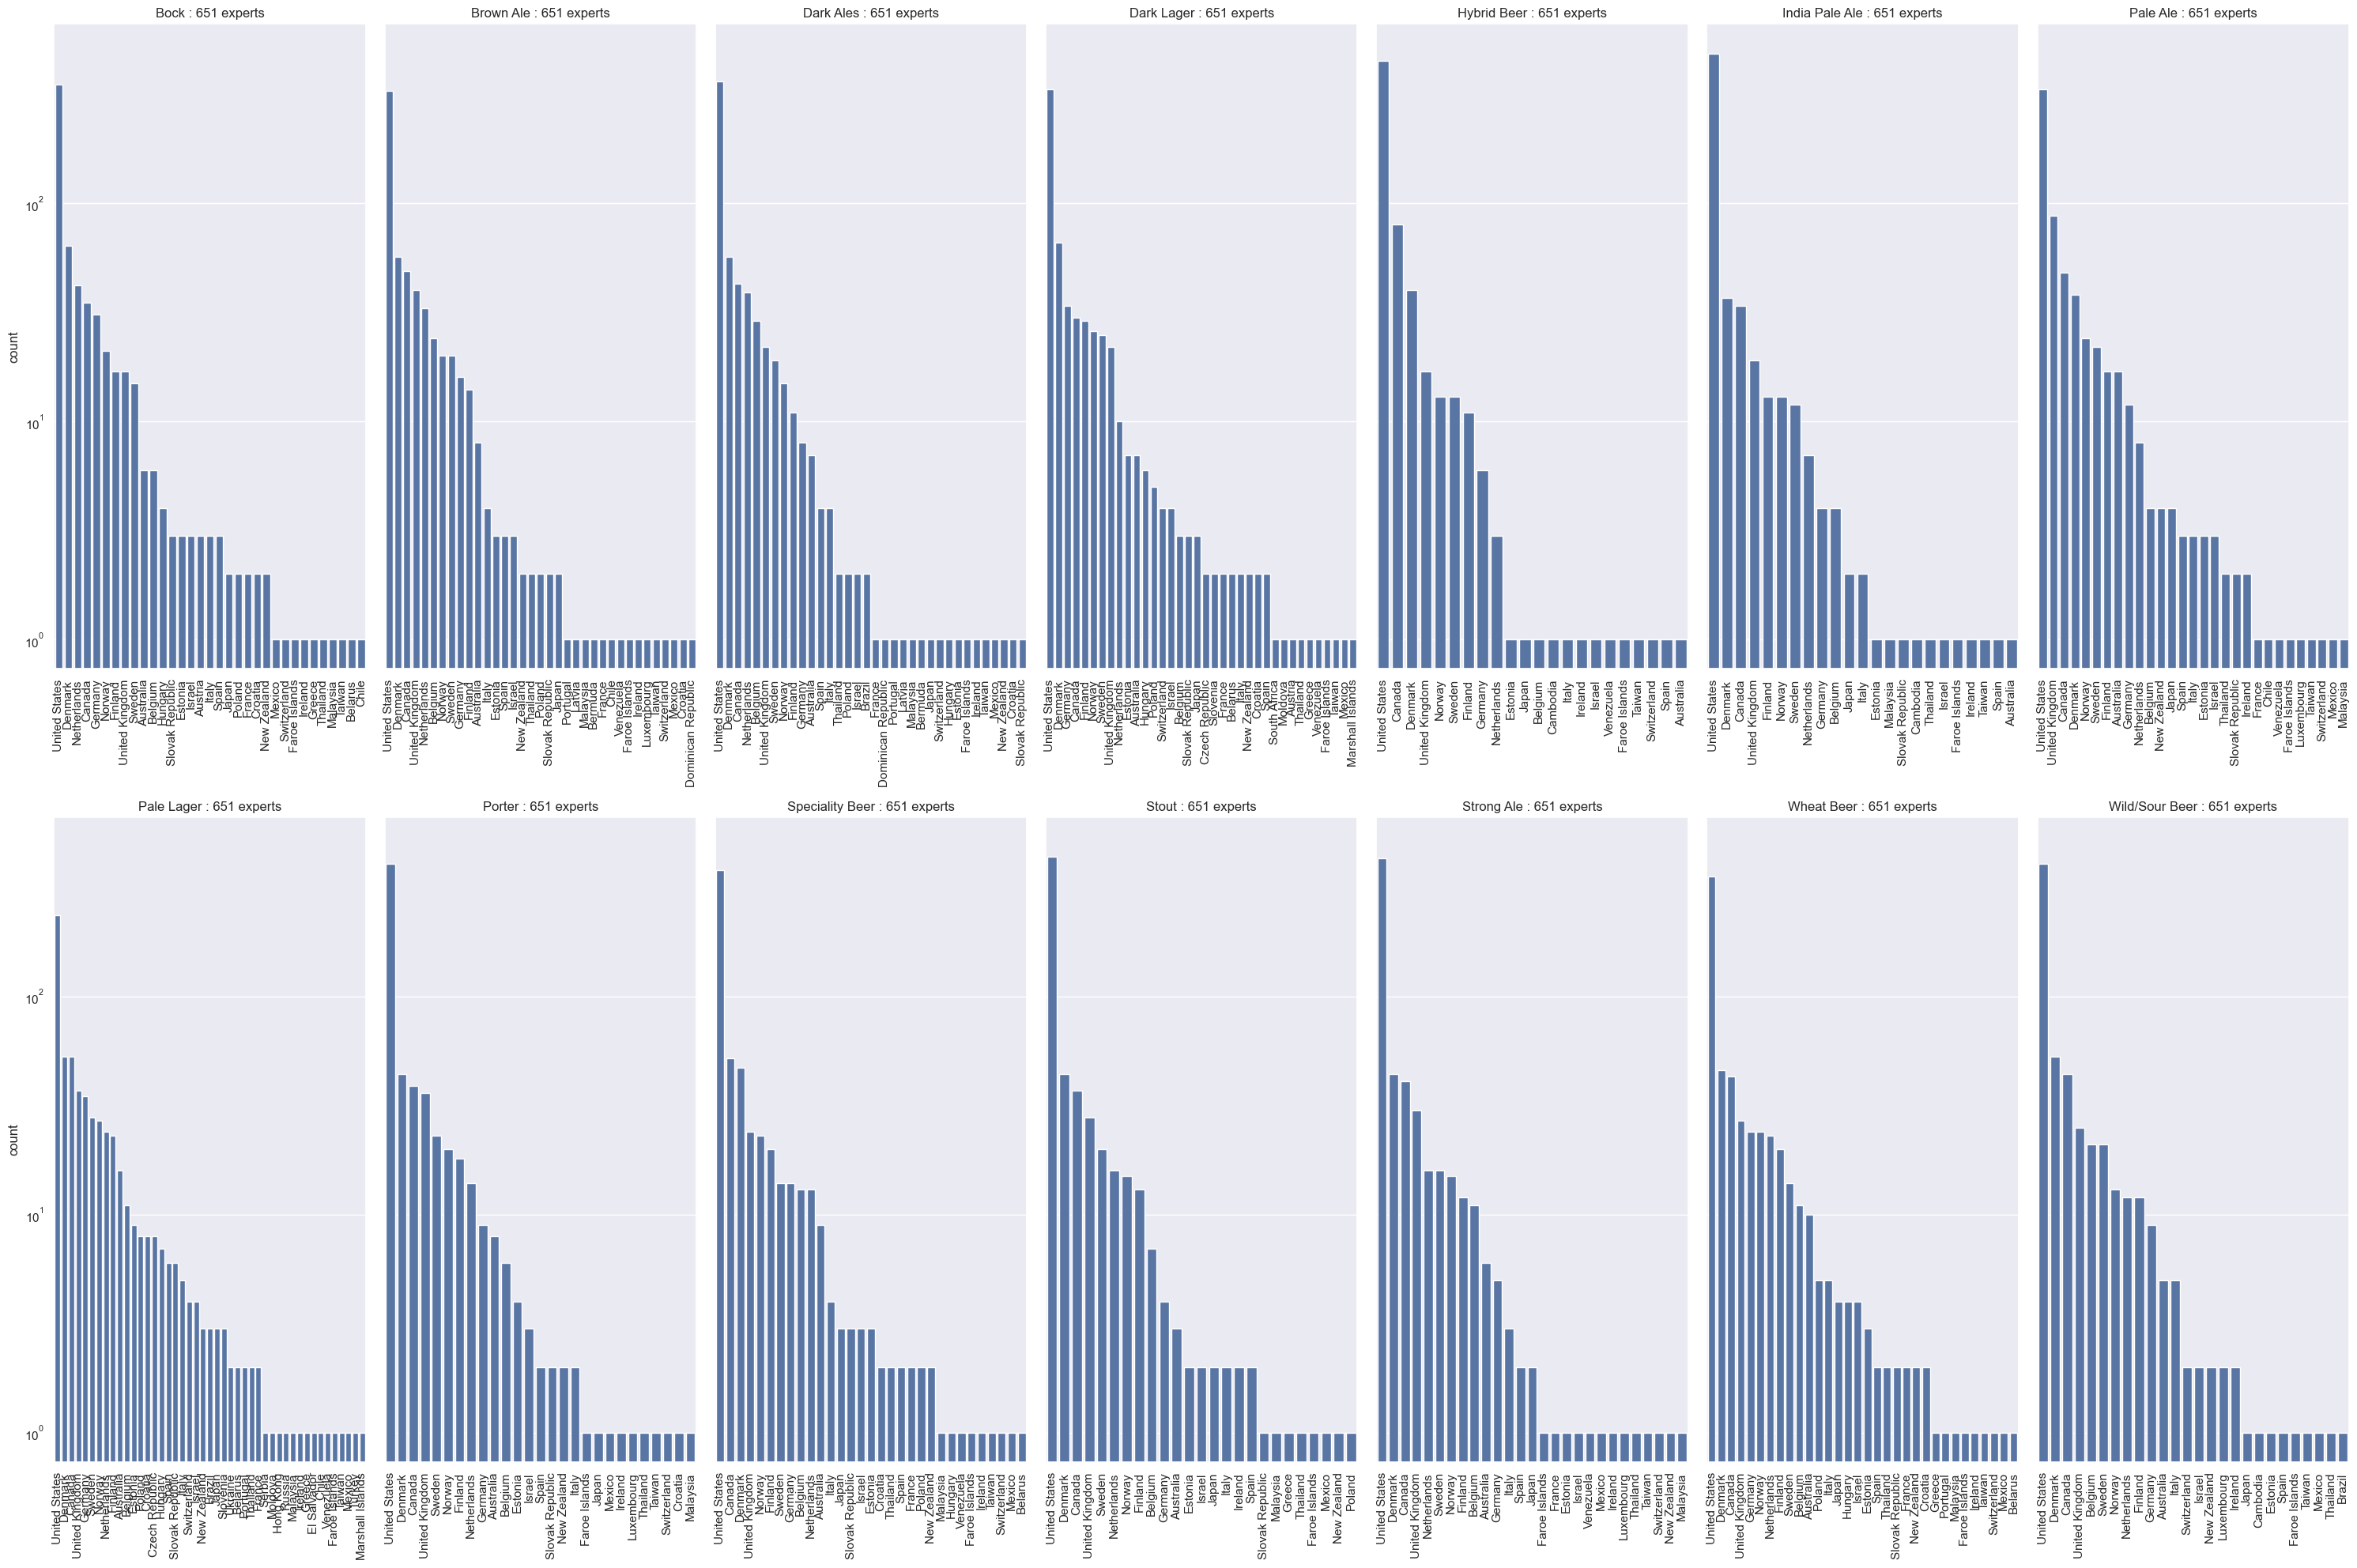

In [424]:
fig, axes = plt.subplots(2,7,figsize=(30,20),sharey=True)
for col_idx, col in enumerate(expert_columns):
    sns.barplot(df_expert_users[df_expert_users[col] == 1]["user_country"].value_counts(), ax=axes[col_idx//7,col_idx%7])
    #axes[col_idx//7,col_idx%7].set_xticklabels(rotation=90)
    axes[col_idx//7,col_idx%7].set_xticklabels(axes[col_idx//7,col_idx%7].get_xticklabels(), rotation=90)
    axes[col_idx//7,col_idx%7].set_xlabel("")
    #plt.ylabel(f"Number of local experts in {col.split("_")[0]}")
    axes[col_idx//7,col_idx%7].set_title(f"{col.split("_")[0]} : {df_expert_users[col].sum()} experts")
    axes[col_idx//7,col_idx%7].set_yscale("log")

plt.tight_layout()
plt.show()

In [425]:
n_unique_experts_per_style.sort_values()

Bock_expert               651
Brown Ale_expert          651
Dark Ales_expert          651
Dark Lager_expert         651
Hybrid Beer_expert        651
India Pale Ale_expert     651
Pale Ale_expert           651
Pale Lager_expert         651
Porter_expert             651
Speciality Beer_expert    651
Stout_expert              651
Strong Ale_expert         651
Wheat Beer_expert         651
Wild/Sour Beer_expert     651
dtype: int64

In [426]:
df_rb_user_beer_style_past_ratings['date_month'] = pd.to_datetime(df_rb_ratings['date'], unit="s").dt.to_period("M").dt.start_time
df_rb_user_beer_style_past_ratings['date_quarter'] = pd.to_datetime(df_rb_ratings['date'], unit="s").dt.to_period("Q").dt.start_time

In [427]:
df_expert_per_day = df_rb_user_beer_style_past_ratings[expert_columns+["date_quarter","user_id"]].groupby(["user_id","date_quarter"]).max().reset_index().iloc[:,1:].groupby("date_quarter").sum().reset_index()
df_expert_per_day_long = df_expert_per_day.melt(id_vars='date_quarter', var_name='Beer Style', value_name='Number of expert ratings')

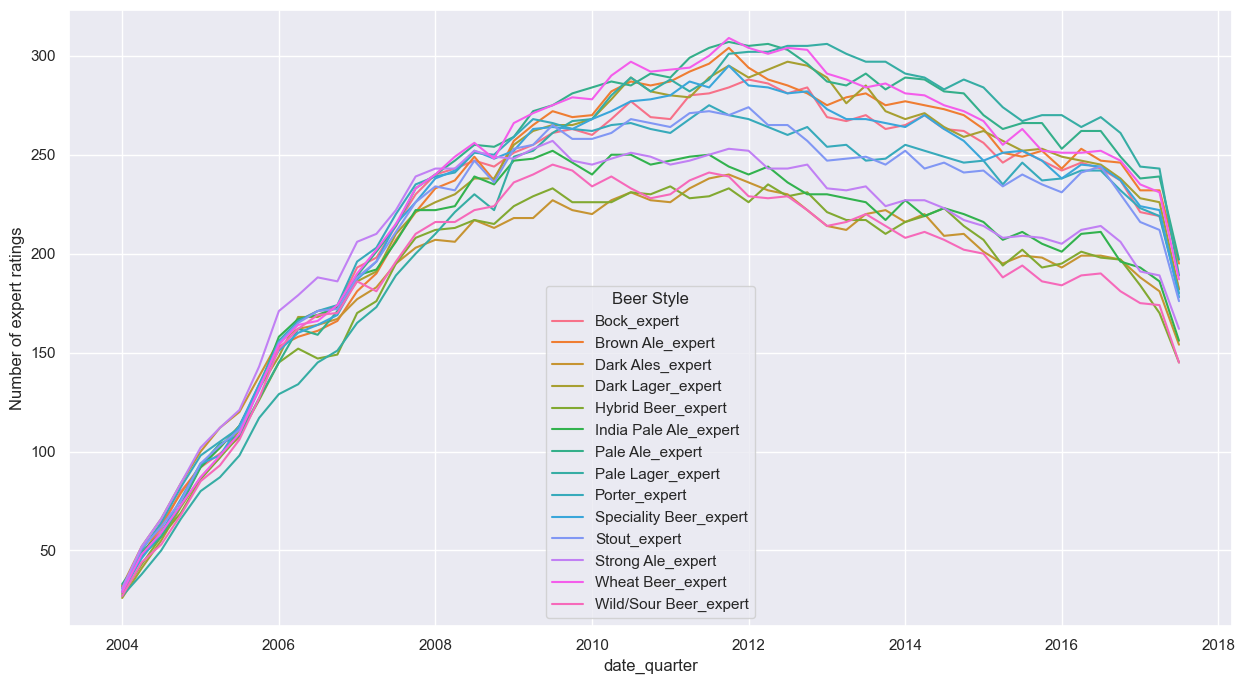

In [428]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df_expert_per_day_long,x="date_quarter",y='Number of expert ratings', hue="Beer Style")
plt.show()

In [429]:
df_expert_ratings = df_rb_user_beer_style_past_ratings[expert_columns+["date_day","user_id","beer_id"]].groupby(["user_id","date_day"]).max().reset_index().merge(df_rb_ratings[["user_id","date_day","beer_global_style","rating"]], how="inner", on=["user_id","date_day"])
df_to_plots = []
TOP_K_BEERS_THRESH = 100
for style in expert_columns:
    beer_rated_by_experts = df_expert_ratings[(df_expert_ratings[style] == 1)]["beer_id"].unique()
    top_k_beers = df_ba_ratings[(df_ba_ratings["beer_global_style"] == style.split("_")[0]) & (df_ba_ratings["beer_id"].isin(beer_rated_by_experts))][["rating","beer_id"]].groupby("beer_id").count().reset_index().sort_values(by="rating",ascending=False).head(TOP_K_BEERS_THRESH)["beer_id"].to_numpy()
    df_same_beers = df_expert_ratings[(df_expert_ratings["beer_global_style"] == style.split("_")[0]) & (df_expert_ratings["beer_id"].isin(top_k_beers))]
    df_to_plots.append(df_same_beers[["beer_global_style","rating",style]].rename(columns={style:"expert"}))
df_to_barplot = pd.concat(df_to_plots,axis=0)

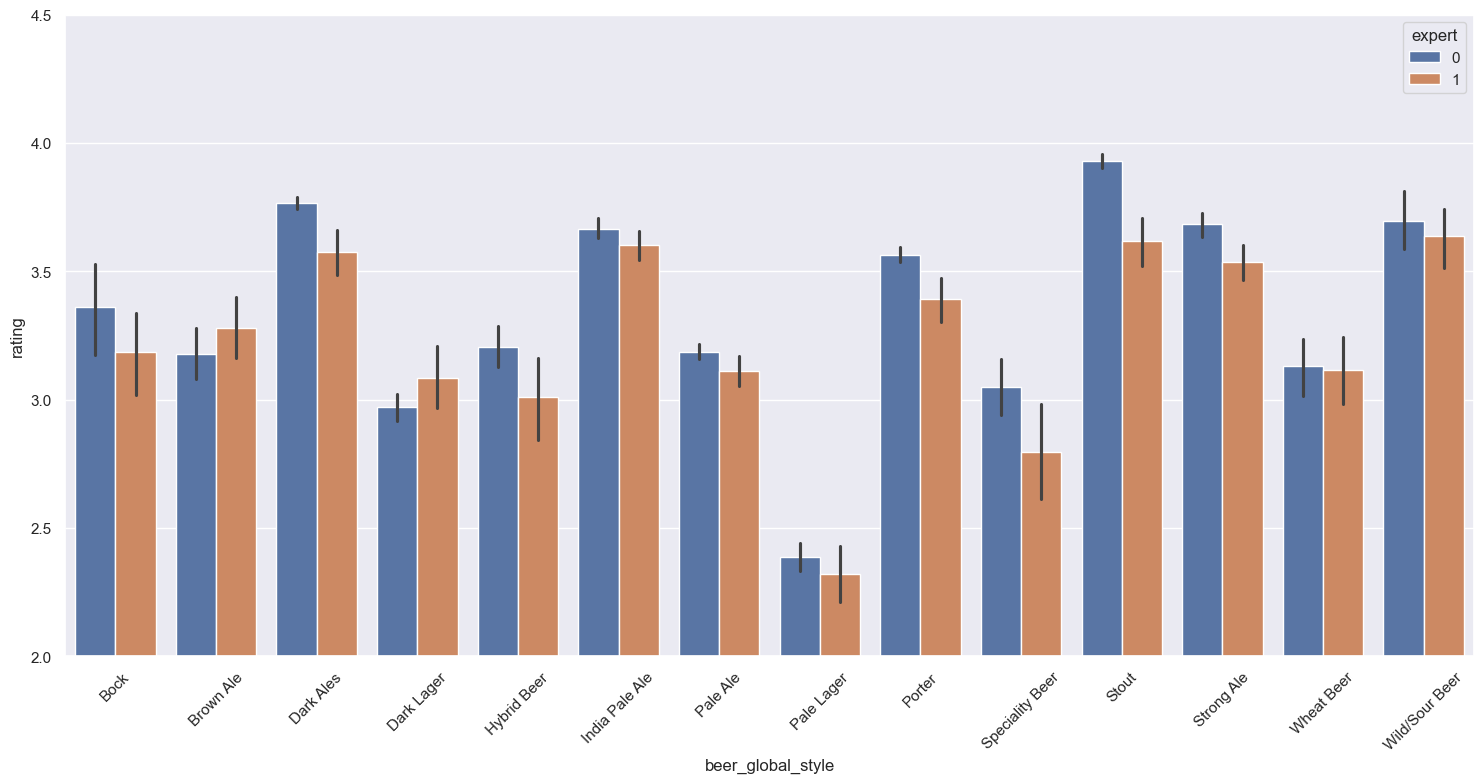

In [430]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_to_barplot,x="beer_global_style", y="rating", hue="expert")
#plt.errorbar(x=df_to_show["beer_global_style"], y=df_to_show["rating"]["mean"], yerr=df_to_show["rating"]["sem"], fmt="none", c="black", capsize=5)
plt.xticks(rotation=45)
plt.ylim([2,4.5])
plt.tight_layout()
plt.show()

In [431]:
df_experts = df_rb_user_beer_style_past_ratings[expert_columns+["user_id","date_day"]]
df_rb_ratings = df_rb_ratings.dropna()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1726109946.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1726109946.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/1726109946.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

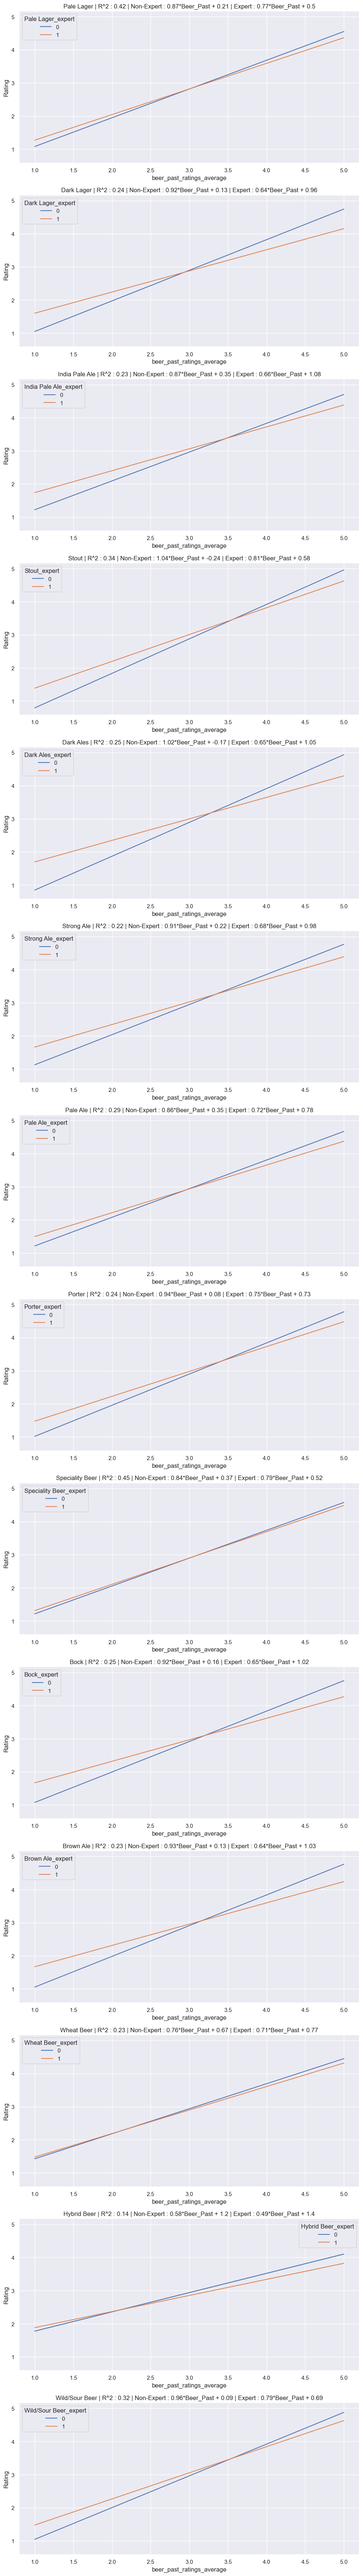

In [432]:
fig, axes = plt.subplots(14,1,figsize=(10,70),sharey=True)

for style_idx, beer_style in enumerate(df_rb_ratings["beer_global_style"].unique()):

    df_study = df_rb_ratings[df_rb_ratings["beer_global_style"] == beer_style][["user_id","date_day","beer_past_ratings_average","rating"]].merge(df_experts, how="left", on=["user_id","date_day"])
    X = df_study[[beer_style+"_expert", 'beer_past_ratings_average']]
    X.loc[:,"interaction"] = X[beer_style+"_expert"] * X["beer_past_ratings_average"]
    X.loc[:,"intercept"] = 1
    y = df_study['rating']
    reg = sm.OLS(y, X).fit()
    df_line = pd.DataFrame({beer_style+"_expert":[0,0,1,1],'beer_past_ratings_average':[1.0,5.0,1.0,5.0],'interaction':[0,0,1.0,5.0],'intercept':[1,1,1,1]})
    #df_line = pd.DataFrame({beer_style+"_expert":[0,0,1,1],'beer_past_ratings_average':[1.0,5.0,1.0,5.0],'interaction':[0,0,1.0,5.0]})

    prediction = reg.get_prediction(df_line)
    predicted_mean = prediction.predicted_mean
    conf_int = prediction.conf_int()

    df_line["predicted_rating"] = predicted_mean
    df_line["ci_lower"] = conf_int[:, 0]
    df_line["ci_upper"] = conf_int[:, 1]

    sns.lineplot(data = df_line, x = "beer_past_ratings_average", y = "predicted_rating", hue = beer_style+"_expert", legend=True, ax=axes[style_idx])
    axes[style_idx].set_title(f"{beer_style} | R^2 : {round(reg.rsquared.item(),2)} | Non-Expert : {round(reg.params["beer_past_ratings_average"],2)}*Beer_Past + {round(reg.params["intercept"],2)} | Expert : {round(reg.params["beer_past_ratings_average"] + reg.params["interaction"],2)}*Beer_Past + {round(reg.params["intercept"] + reg.params[beer_style+"_expert"],2)}")
    #axes[style_idx].set_title(f"{beer_style} | R^2 : {round(reg.rsquared.item(),2)} | Non-Expert : {round(reg.params["beer_past_ratings_average"],2)}*Beer_Past | Expert : {round(reg.params["beer_past_ratings_average"] + reg.params["interaction"],2)}*Beer_Past + {round(reg.params[beer_style+"_expert"],2)}")
    axes[style_idx].set_ylabel("Rating")

    for expert in df_line[beer_style+"_expert"].unique():
        expert_data = df_line[df_line[beer_style+"_expert"] == expert]
        axes[style_idx].fill_between(
            expert_data["beer_past_ratings_average"], 
            expert_data["ci_lower"], 
            expert_data["ci_upper"], 
            alpha=0.2  # Adjust transparency of the shaded region
        )
plt.tight_layout()
plt.show()

# Graphical Approach of experts

## Shell Layout with nodes as expertise kind and beer styles

In [433]:
import networkx as nx
import community as community_louvain

MIN_EXPERT = 70
SIZE_STYLE = 1000
SIZE_EXPERT_MIN = 500

In [434]:
G = nx.Graph()

styles = df_rb_ratings["beer_global_style"].unique()
styles.sort()

styles_total = df_expert_users.iloc[:,1:-2].sum().to_dict()

user_expertise = dict()

for row in df_expert_users.iterrows():
    expertise = []
    for style_idx, style in enumerate(styles):
        if row[1][style_idx + 1] == 1:
            expertise.append(style)
    user_expertise[row[1][0]] = expertise

expertise_kinds = []
for val in user_expertise.values():
    if val not in expertise_kinds:
        expertise_kinds.append(val)

edge_sizes = []
for i, expertise in enumerate(expertise_kinds):
    size = list(user_expertise.values()).count(expertise)
    if size >= MIN_EXPERT and len(expertise) >= 2:
        G.add_node(str(i))
        for style in expertise:
            G.add_edge(style,str(i))
            expert_share = 100 * (size / styles_total[style+"_expert"])
            edge_sizes.append(expert_share)

colors = ["red","green","blue","orange","purple","cyan","magenta","yellow","pink","lime","teal","brown","gray","olive"]
kind_to_color_bis = {styles[i]:colors[i] for i in range(len(styles))}

edge_colors = []
for u,v in G.edges():
    if u in styles:
        edge_colors.append(kind_to_color_bis[u])
    else:
        edge_colors.append(kind_to_color_bis[v])

node_sizes = []
node_colors = []
experts = []
for node in G.nodes():
    if node in styles:
        node_sizes.append(SIZE_STYLE)
        node_colors.append(kind_to_color_bis[node])
    else:
        experts.append(node)
        expertises = expertise_kinds[int(node)]
        node_sizes.append(SIZE_EXPERT_MIN + list(user_expertise.values()).count(expertises))
        node_colors.append("black")

shells = [styles, experts]
pos = nx.shell_layout(G, shells)

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/3789412746.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_4843/3789412746.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



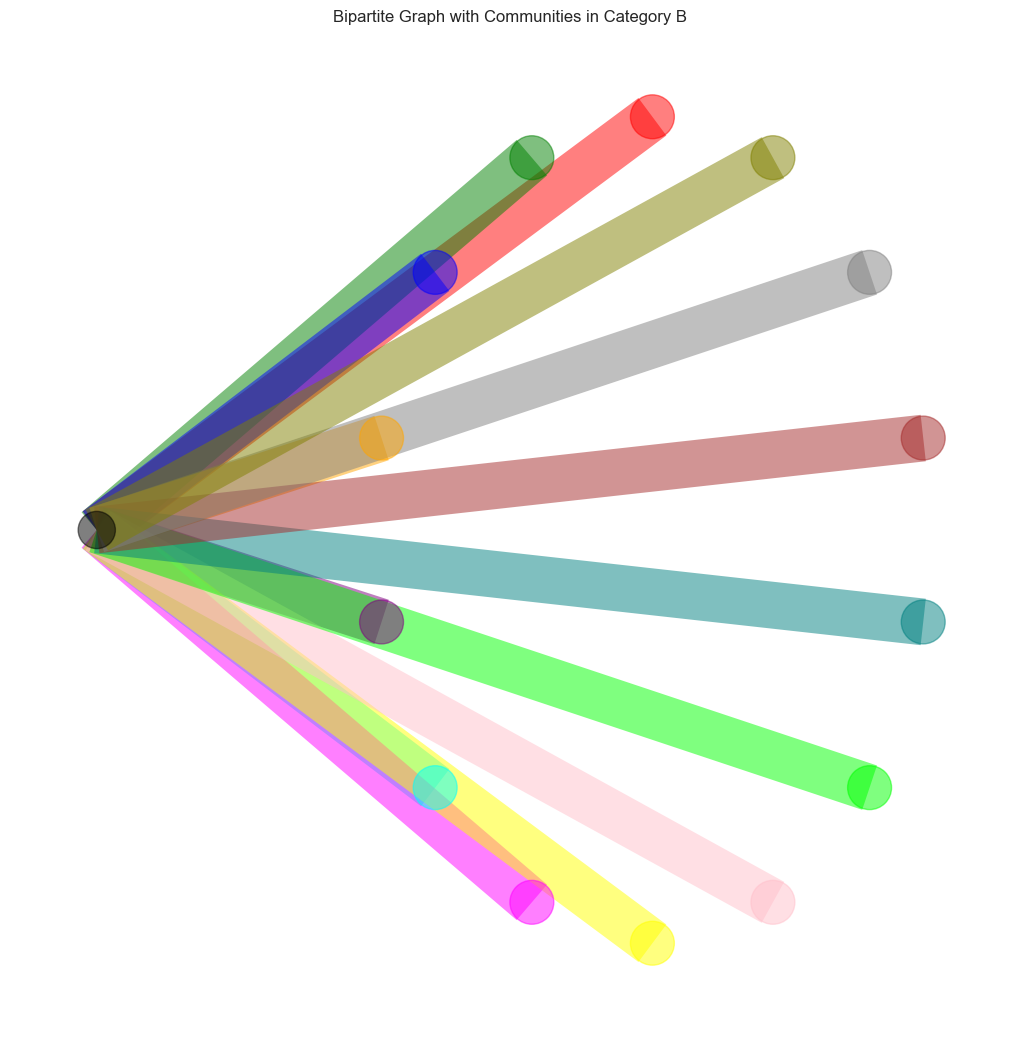

In [435]:
plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color=edge_colors,
    width=edge_sizes,
    alpha=0.5
)
plt.title("Bipartite Graph with Communities in Category B")
plt.show()

## Spring layout with nodes as users and beer styles

In [436]:
G_bis = nx.Graph()

styles = df_rb_ratings["beer_global_style"].unique()
styles.sort()

G_bis.add_nodes_from(styles)
G_bis.add_nodes_from(df_expert_users["user_id"])

df_expert_users_renamed = df_expert_users.rename(columns={style+"_expert":style for style in styles}).iloc[:,:-2]
df_edges = df_expert_users_renamed.melt(id_vars="user_id",var_name="style",value_name="edge")
G_bis.add_edges_from(df_edges[df_edges["edge"] == 1][["user_id","style"]].values)

nodes_to_remove = [node for node in G_bis.nodes() if G_bis.degree(node) == 1]

G_bis.remove_nodes_from(nodes_to_remove)

node_sizes = []
node_colors = []
for node in G_bis.nodes():
    if node in styles:
        node_sizes.append(500)
        node_colors.append("red")
    else:
        node_colors.append("blue")
        node_sizes.append(10)

user_nodes = [node for node in G_bis.nodes() if node in df_expert_users_renamed["user_id"]]
style_nodes = [node for node in G_bis.nodes() if node in styles]

all_pos = nx.spring_layout(G_bis, seed=42)

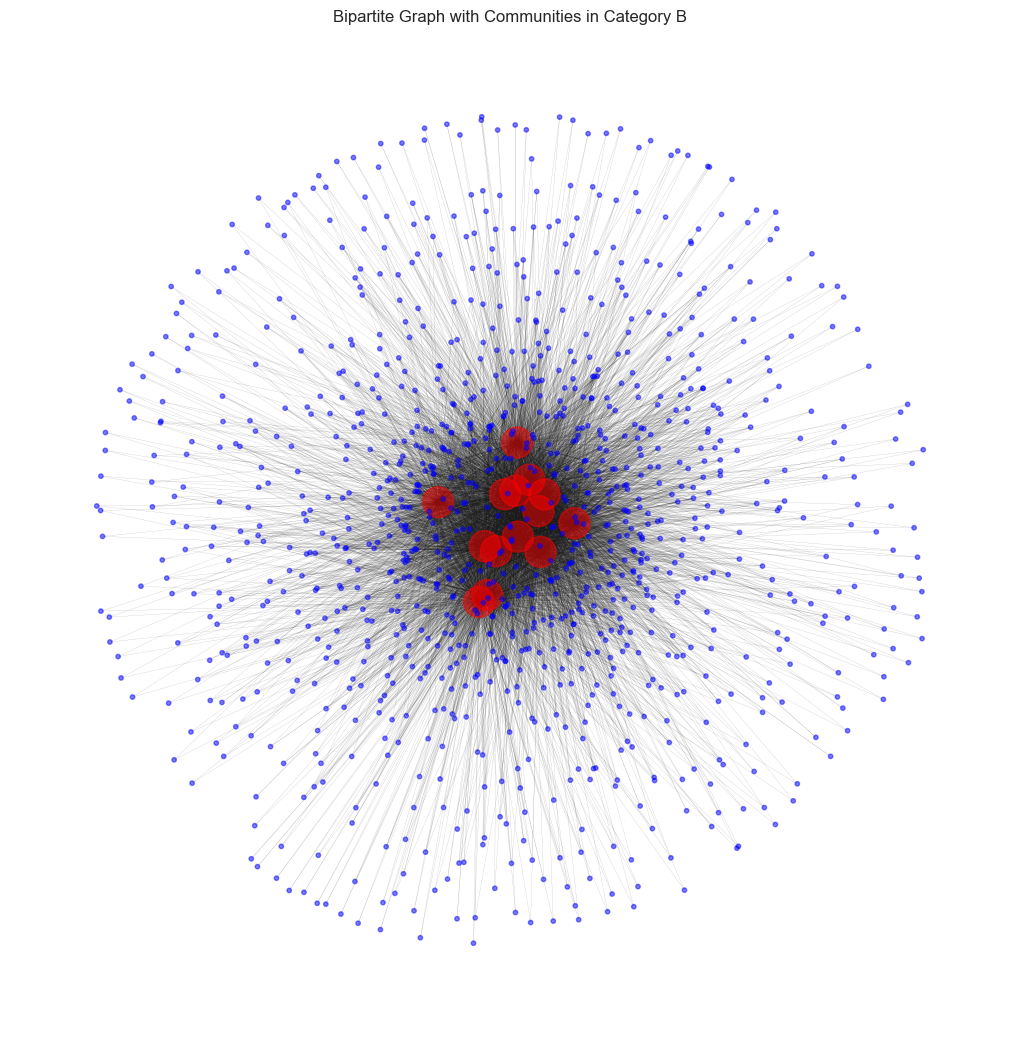

In [437]:
plt.figure(figsize=(10, 10))
nx.draw(
    G_bis,
    all_pos,
    node_size=node_sizes,
    node_color=node_colors,
    width=0.1,
    alpha=0.5
)
plt.title("Bipartite Graph with Communities in Category B")
plt.show()